In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,Conv2DTranspose, Flatten, Reshape, LeakyReLU, Dropout
from keras.models import Model, Sequential
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import cv2 as cv
from tqdm import tqdm, trange
from matplotlib import image as mpimg

# Jamming anomaly detection
This python code aims to detect white noise jamming throught the use of machine learning to perform anomaly detection.
\
Constellation diagrams from a cellular wireless channel were taken, and then a ML tool was trained in order to make it learn only what is a "trusted" transmission.
\
By training using only the one class, the detector should recognise only what we consider in prior "trusted", and classify anything else as an anomaly.
\
\
The tool used to perform this operation is a Convolutional Neural Network with a specific structure called *autoencoder*.
\
An autoencoder is a neural network that is composed of two parts: the encoder and the decoder.
<ul>

 <li>the encoder takes the input and performs some operations (such as filtering, pooling etc..) in order to convert it to a lower dimensional space.</li>
 <li>the decoder takes the output of the endcoder and tries to reconstruct the original input.</li>
</ul>
This implies that if the autoencoder is trained only with a dataset composed by only one class, it will learn to reconstruct well only that class.
<br>
In this case, the autoencoder will be fed with i/q diagrams of the cellular wireless channel in the two trusted situations: "Transmitting" in which the cellular device is trasmitting data to the base station and "Empty" in which the cellular device is not transmitting any data to the base station.
<br>
<br>
After that, the mean and the standard deviation of the reconstruction error from the validation set will be computed in order to decide a threshold above that an image is considered an anomaly; in this case the threshold will be set set to mean + stdv.
<br>
At the end, evalutation of the neural network will be performed on a test set composed of 800 images: 400 images are taken from the "trusted" case and 400 are taken from the "jammed case".
<br>
Accuracy of the neural network will be computed by first computing its accuracy(the sum of True positive and true negative samples divided by the length of the test set), then by plotting the confusion matrix in order to show the distribution of the four main KPIs (true positive, true negative, false positive and false negative) in order to have a better overview of the performance of the classifier. 

In [2]:
#name mapping
classes = {0:"clean",1:"jammed"}
mapping={0:0, 1:0, 2:1} ## dictionaries to label the dataset

In [3]:
!pip install -U --no-cache-dir gdown --pre
!pip install --upgrade gdown
import gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#downloading the dataset with 1024 of gaussian noise
url = "https://drive.google.com/u/0/uc?id=1f9gxP3v6ystFbZgf2blIzcpUNk4BFV4C&export=download"
output = "data_gaussian_1024.zip"
gdown.download(url, output)
!unzip data_gaussian_1024.zip

Downloading...
From (uriginal): https://drive.google.com/u/0/uc?id=1f9gxP3v6ystFbZgf2blIzcpUNk4BFV4C&export=download
From (redirected): https://drive.google.com/uc?id=1f9gxP3v6ystFbZgf2blIzcpUNk4BFV4C&export=download&confirm=t&uuid=9f50838d-b5f0-4b64-94e5-2fc5b6e0a61a
To: /content/data_gaussian_1024.zip
100%|██████████| 158M/158M [00:01<00:00, 81.7MB/s]


Output streaming troncato alle ultime 5000 righe.
  inflating: data_gaussian_1024/jammed_channel/images/2_104.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_105.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_106.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_107.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_108.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_109.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_110.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_111.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_112.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_113.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_114.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_115.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_116.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_117.png  
  inflating: data_gaussian

In [5]:
clean = []
labels_clean =[]
val = []
labels_val =[]
anomalies = []
labels_anomalies =[]
test=[]
labels_test=[]
## empty arrays that will contain the images of the four datasets and the labels of the corresponding images; in this case 0 is a clean channel and 1 is a jammed channel
for folder in tqdm(os.listdir("data_gaussian_1024")):
  print(folder)
  for im in tqdm(os.listdir("data_gaussian_1024/"+folder+"/images/")):
      if folder == "clean":
          clean.append(cv.cvtColor(cv.resize(cv.imread("data_gaussian_1024/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
          labels_clean.append(0)
      elif folder == "clean_validation":
          val.append(cv.cvtColor(cv.resize(cv.imread("data_gaussian_1024/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
          labels_val.append(0)
      elif folder== "jammed_channel":
          anomalies.append(cv.cvtColor(cv.resize(cv.imread("data_gaussian_1024/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
          labels_anomalies.append(1)
      else:
        test.append(cv.cvtColor(cv.resize(cv.imread("data_gaussian_1024/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
        labels_test.append(mapping[int(im[0])])
  ## the images were loaded and put in the lists, but was performed also the resize of the image to 128x128 and conversion of the colorspace from rgb to grayscale
                    

  0%|          | 0/4 [00:00<?, ?it/s]

clean_validation



 25%|██▌       | 1/4 [00:03<00:09,  3.05s/it]

jammed_channel



 50%|█████     | 2/4 [00:05<00:05,  2.79s/it]

test



 75%|███████▌  | 3/4 [00:10<00:03,  3.72s/it]

clean



100%|██████████| 4/4 [00:31<00:00,  7.82s/it]


In [6]:
clean[60].shape ## test only to see if i have an image with the correct size

(128, 128, 1)

In [7]:
## define our neural network
class AutoEncoder(Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Sequential([
            Conv2D(64, 3, strides=2, padding="same", activation="sigmoid", input_shape=(128,128,1)),
            Conv2D(32, 3, strides=2, padding="same", activation="sigmoid"),
            Flatten(),
            Dense(32, activation = "sigmoid")
        ])
        self.decoder = Sequential([                            
            Dense(32*32*32, activation="sigmoid",input_shape=self.encoder.output.shape[1:]),
            Reshape((32,32,32)),
            Conv2DTranspose(32, 3, strides=2, padding="same", activation="sigmoid"),
            Conv2DTranspose(64, 3, strides=2, padding="same", activation="sigmoid"),
            Conv2D(1, 3, strides=1, padding="same", activation="sigmoid")
        ])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [8]:
model = AutoEncoder()

model.compile(optimizer='adam', loss="mse")
print(model.encoder.summary())
print(model.decoder.summary())
## print the summary of the autoencoder 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 32)                1048608   
                                                                 
Total params: 1,067,712
Trainable params: 1,067,712
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)   

Summary of the encoder:



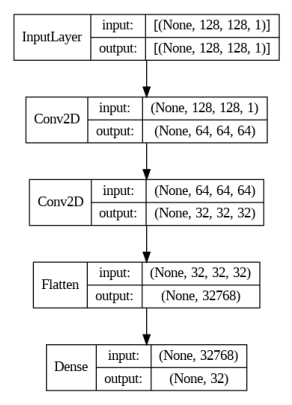

Summary of the decoder:



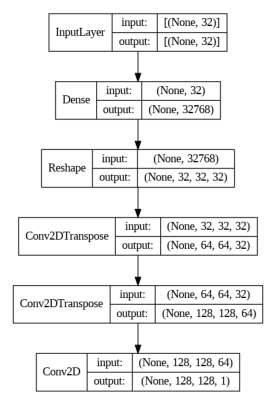

In [ ]:
##plot a scheme of the neural network
print("Summary of the encoder:\n")
image = mpimg.imread("model_encoder.png")
plt.figure(figsize=(5,5))
plt.axis("off")
plt.imshow(image)
plt.show()
print("Summary of the decoder:\n")
image = mpimg.imread("model_decoder.png")
plt.figure(figsize=(5,5))
plt.axis("off")
plt.imshow(image)
plt.show()

In [9]:
history=model.fit(
        x=np.array(clean)/255.,
        y=np.array(clean)/255.,
        batch_size=32,
        epochs=20,
        verbose=True,
        validation_data=(np.array(val)/255.,np.array(val)/255.), 
        shuffle=True,
    )
## the input of the NN is normalized

## training the NN and computing the error also in the validation set

Epoch 1/20
125/125 [==============================] - 19s 54ms/step - loss: 0.0424 - val_loss: 0.0362
Epoch 2/20
125/125 [==============================] - 6s 45ms/step - loss: 0.0354 - val_loss: 0.0355
Epoch 3/20
125/125 [==============================] - 5s 43ms/step - loss: 0.0345 - val_loss: 0.0336
Epoch 4/20
125/125 [==============================] - 5s 43ms/step - loss: 0.0303 - val_loss: 0.0286
Epoch 5/20
125/125 [==============================] - 6s 46ms/step - loss: 0.0281 - val_loss: 0.0281
Epoch 6/20
125/125 [==============================] - 5s 44ms/step - loss: 0.0278 - val_loss: 0.0279
Epoch 7/20
125/125 [==============================] - 6s 46ms/step - loss: 0.0277 - val_loss: 0.0279
Epoch 8/20
125/125 [==============================] - 6s 46ms/step - loss: 0.0276 - val_loss: 0.0278
Epoch 9/20
125/125 [==============================] - 5s 44ms/step - loss: 0.0276 - val_loss: 0.0278
Epoch 10/20
125/125 [==============================] - 6s 46ms/step - loss: 0.0276 - val_l

In [ ]:
model.save("AUTOENCODER_model")
np.save("AUTOENCODER_history.npy", history.history)
print(output.OKGREEN+"Autoencoder saved"+output.END)

else:



  !unzip AUTOENCODER_model.zip

  model = keras.models.load_model("content/AUTOENCODER_model")

  history = np.load("AUTOENCODER_history.npy", allow_pickle = "TRUE").item()

  print(output.OKGREEN+"Autoencoder loaded"+output.END)
## for saving purposes: DONT EXECUTE!! 

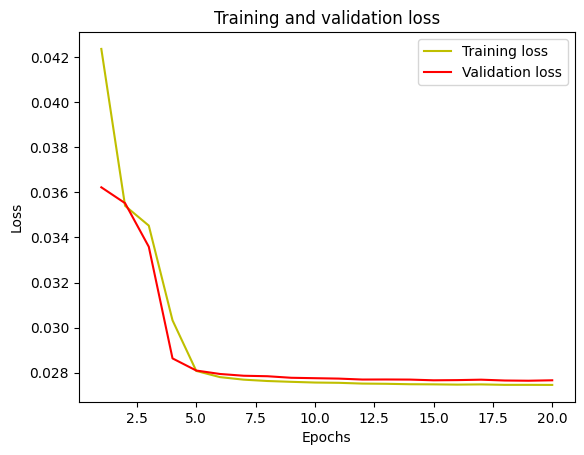

In [10]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
predicted = model.predict((np.array(val))/255.) ## reconstruct some images

19/19 [==============================] - 1s 25ms/step


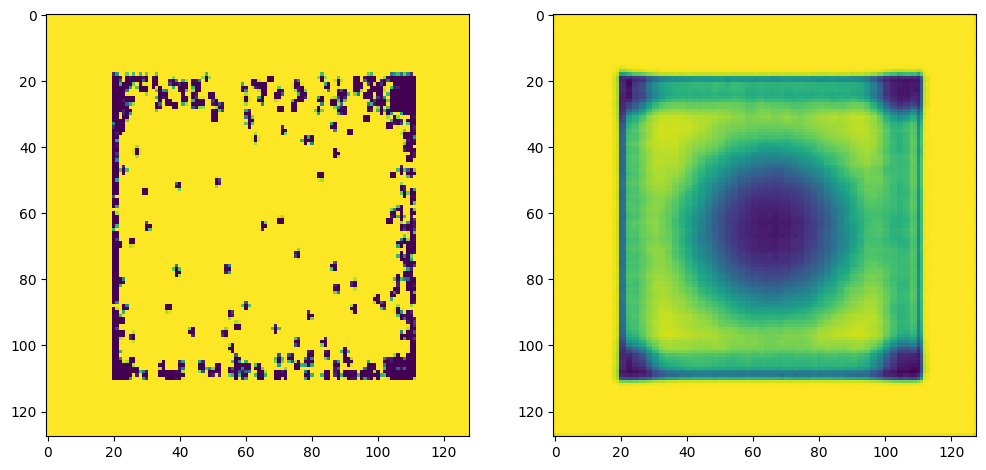

In [13]:
##view few images and corresponding reconstructions
image_number = random.randint(0, predicted.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(val[image_number])
plt.subplot(122)
plt.imshow(predicted[image_number])
plt.show()
## examples of the reconstruction of the images, as we can see, the NN has learnt what are the two cases of the channel: "transmitting", in which we can see dots
## that form a square, and "empty", in which we see all the dots concentrated around the origin of the axis

In [14]:
validation_error = model.evaluate((np.array(val)/255.),(np.array(val)/255.))
anomaly_error = model.evaluate((np.array(anomalies)/255.),(np.array(anomalies)/255.))
print("Validation error", validation_error)
print("Anomaly error", anomaly_error)
print("The reconstruction error of the jammed channel is ",anomaly_error/validation_error," more than the clean channel" )
## check if the reconstruction error is higher on some anomaly images

16/16 [==============================] - 1s 53ms/step - loss: 0.0295
Validation error 0.027666280046105385
Anomaly error 0.029543109238147736
The reconstruction error of the jammed channel is  1.0678381476987382  more than the clean channel


In [15]:
## functions that computes the mean and the stdv of the reconstruction error
def calc_recon_error(batch_images):

    recon_error_list=[]
    for im in trange(0, batch_images.shape[0]):
        
        img  = batch_images[im]
        img= img.reshape(1,128,128,1)
        recon_error_list.append(model.evaluate(img,img))
         
    
    average_recon_error = np.mean(np.array(recon_error_list))  
    stdev_recon_error = np.std(np.array(recon_error_list)) 
    
    return average_recon_error, stdev_recon_error

In [16]:
normal_values = calc_recon_error(np.array(val)/255.)
jammed_values = calc_recon_error(np.array(anomalies)/255.)
## compute the statistics on the reconstruction error of both cases

  0%|          | 0/600 [00:00<?, ?it/s]

1/1 [==============================] - 0s 171ms/step - loss: 0.0281


  0%|          | 1/600 [00:00<03:32,  2.81it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0280


  0%|          | 3/600 [00:00<02:21,  4.20it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0286


  1%|          | 5/600 [00:00<01:29,  6.61it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0277


  1%|          | 7/600 [00:01<01:08,  8.60it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0276


  2%|▏         | 9/600 [00:01<00:57, 10.25it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0273


  2%|▏         | 11/600 [00:01<00:52, 11.14it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0305


  2%|▏         | 13/600 [00:01<00:48, 12.09it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0252


  2%|▎         | 15/600 [00:01<00:45, 12.82it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0283


  3%|▎         | 17/600 [00:01<00:42, 13.75it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0268


  3%|▎         | 19/600 [00:01<00:40, 14.24it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0285


  4%|▎         | 21/600 [00:01<00:38, 14.93it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0248


  4%|▍         | 23/600 [00:02<00:37, 15.47it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0241


  4%|▍         | 25/600 [00:02<00:36, 15.56it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0277


  4%|▍         | 27/600 [00:02<00:38, 14.86it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0234


  5%|▍         | 29/600 [00:02<00:38, 14.82it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0285


  5%|▌         | 31/600 [00:02<00:39, 14.49it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0287


  6%|▌         | 33/600 [00:02<00:39, 14.36it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0290


  6%|▌         | 35/600 [00:02<00:39, 14.34it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0232


  6%|▌         | 37/600 [00:03<00:39, 14.36it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0292


  6%|▋         | 39/600 [00:03<00:38, 14.58it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0294


  7%|▋         | 41/600 [00:03<00:37, 14.95it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0314


  7%|▋         | 43/600 [00:03<00:36, 15.16it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0261


  8%|▊         | 45/600 [00:03<00:38, 14.46it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0305


  8%|▊         | 47/600 [00:03<00:37, 14.60it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0253


  8%|▊         | 49/600 [00:03<00:37, 14.74it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0276


  8%|▊         | 51/600 [00:03<00:36, 15.05it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0286


  9%|▉         | 53/600 [00:04<00:37, 14.40it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0277


  9%|▉         | 55/600 [00:04<00:37, 14.62it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0257


 10%|▉         | 57/600 [00:04<00:37, 14.67it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0290


 10%|▉         | 59/600 [00:04<00:36, 14.68it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0297


 10%|█         | 61/600 [00:04<00:37, 14.38it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0275


 10%|█         | 63/600 [00:04<00:36, 14.78it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0286


 11%|█         | 65/600 [00:04<00:36, 14.49it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0266


 11%|█         | 67/600 [00:05<00:36, 14.66it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0284


 12%|█▏        | 69/600 [00:05<00:35, 14.80it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0286


 12%|█▏        | 71/600 [00:05<00:34, 15.19it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0277


 12%|█▏        | 73/600 [00:05<00:33, 15.59it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0279


 12%|█▎        | 75/600 [00:05<00:34, 15.31it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0302


 13%|█▎        | 77/600 [00:05<00:34, 15.14it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0229


 13%|█▎        | 79/600 [00:05<00:34, 14.94it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0292


 14%|█▎        | 81/600 [00:05<00:33, 15.28it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0273


 14%|█▍        | 83/600 [00:06<00:34, 15.09it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0276


 14%|█▍        | 85/600 [00:06<00:34, 14.95it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0291


 14%|█▍        | 87/600 [00:06<00:33, 15.48it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0235


 15%|█▍        | 89/600 [00:06<00:33, 15.39it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0281


 15%|█▌        | 91/600 [00:06<00:33, 15.13it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0267


 16%|█▌        | 93/600 [00:06<00:33, 15.06it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0254


 16%|█▌        | 95/600 [00:06<00:33, 15.08it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0266


 16%|█▌        | 97/600 [00:07<00:32, 15.54it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0300


 16%|█▋        | 99/600 [00:07<00:31, 15.88it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0228


 17%|█▋        | 101/600 [00:07<00:32, 15.27it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0266


 17%|█▋        | 103/600 [00:07<00:32, 15.21it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0300


 18%|█▊        | 105/600 [00:07<00:32, 15.35it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0230


 18%|█▊        | 107/600 [00:07<00:32, 15.22it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0251


 18%|█▊        | 109/600 [00:07<00:33, 14.79it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0279


 18%|█▊        | 111/600 [00:07<00:32, 15.17it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0292


 19%|█▉        | 113/600 [00:08<00:32, 15.07it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0252


 19%|█▉        | 115/600 [00:08<00:32, 15.12it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0245


 20%|█▉        | 117/600 [00:08<00:31, 15.32it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0242


 20%|█▉        | 119/600 [00:08<00:31, 15.29it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0285


 20%|██        | 121/600 [00:08<00:30, 15.46it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0293


 20%|██        | 123/600 [00:08<00:31, 15.23it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0277


 21%|██        | 125/600 [00:08<00:31, 15.00it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0253


 21%|██        | 127/600 [00:09<00:31, 14.99it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0290


 22%|██▏       | 129/600 [00:09<00:31, 15.04it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0286


 22%|██▏       | 131/600 [00:09<00:31, 14.83it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0279


 22%|██▏       | 133/600 [00:09<00:31, 15.06it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0282


 22%|██▎       | 135/600 [00:09<00:31, 14.73it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0271


 23%|██▎       | 137/600 [00:09<00:32, 14.31it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0263


 23%|██▎       | 139/600 [00:09<00:33, 13.68it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0264


 24%|██▎       | 141/600 [00:10<00:36, 12.55it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0264


 24%|██▍       | 143/600 [00:10<00:38, 11.82it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0279


 24%|██▍       | 145/600 [00:10<00:38, 11.87it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0289


 24%|██▍       | 147/600 [00:10<00:38, 11.76it/s]

1/1 [==============================] - 0s 51ms/step - loss: 0.0238


 25%|██▍       | 149/600 [00:10<00:42, 10.62it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0253


 25%|██▌       | 151/600 [00:11<00:42, 10.52it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0226


 26%|██▌       | 153/600 [00:11<00:41, 10.71it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0279


 26%|██▌       | 155/600 [00:11<00:41, 10.76it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0272


 26%|██▌       | 157/600 [00:11<00:41, 10.73it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0244


 26%|██▋       | 159/600 [00:11<00:42, 10.44it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0270


 27%|██▋       | 161/600 [00:11<00:40, 10.72it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0314


 27%|██▋       | 163/600 [00:12<00:40, 10.77it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0231


 28%|██▊       | 165/600 [00:12<00:37, 11.53it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0253


 28%|██▊       | 167/600 [00:12<00:35, 12.23it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0285


 28%|██▊       | 169/600 [00:12<00:34, 12.64it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0300


 28%|██▊       | 171/600 [00:12<00:33, 12.95it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0266


 29%|██▉       | 173/600 [00:12<00:32, 13.34it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0284


 29%|██▉       | 175/600 [00:13<00:31, 13.35it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0286


 30%|██▉       | 177/600 [00:13<00:30, 14.09it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0287


 30%|██▉       | 179/600 [00:13<00:30, 13.81it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0287


 30%|███       | 181/600 [00:13<00:29, 14.15it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0302


 30%|███       | 183/600 [00:13<00:29, 13.99it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0258


 31%|███       | 185/600 [00:13<00:28, 14.35it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0243


 31%|███       | 187/600 [00:13<00:29, 14.07it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0262


 32%|███▏      | 189/600 [00:13<00:28, 14.41it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0263


 32%|███▏      | 191/600 [00:14<00:29, 13.93it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0261


 32%|███▏      | 193/600 [00:14<00:30, 13.51it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0278


 32%|███▎      | 195/600 [00:14<00:29, 13.58it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0279


 33%|███▎      | 197/600 [00:14<00:29, 13.81it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0289


 33%|███▎      | 199/600 [00:14<00:28, 14.05it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0304


 34%|███▎      | 201/600 [00:14<00:27, 14.30it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0282


 34%|███▍      | 203/600 [00:14<00:28, 14.09it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0279


 34%|███▍      | 205/600 [00:15<00:27, 14.59it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0286


 34%|███▍      | 207/600 [00:15<00:27, 14.18it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0286


 35%|███▍      | 209/600 [00:15<00:26, 14.60it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0297


 35%|███▌      | 211/600 [00:15<00:26, 14.66it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0305


 36%|███▌      | 213/600 [00:15<00:26, 14.61it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0268


 36%|███▌      | 215/600 [00:15<00:27, 14.08it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0276


 36%|███▌      | 217/600 [00:15<00:27, 14.02it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0256


 36%|███▋      | 219/600 [00:16<00:27, 14.08it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0236


 37%|███▋      | 221/600 [00:16<00:26, 14.47it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0294


 37%|███▋      | 223/600 [00:16<00:26, 14.06it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0289


 38%|███▊      | 225/600 [00:16<00:26, 13.97it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0298


 38%|███▊      | 227/600 [00:16<00:26, 14.27it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0282


 38%|███▊      | 229/600 [00:16<00:26, 14.14it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0232


 38%|███▊      | 231/600 [00:16<00:25, 14.22it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0229


 39%|███▉      | 233/600 [00:17<00:24, 14.77it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0298


 39%|███▉      | 235/600 [00:17<00:24, 14.84it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0288


 40%|███▉      | 237/600 [00:17<00:24, 15.09it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0271


 40%|███▉      | 239/600 [00:17<00:24, 14.72it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0294


 40%|████      | 241/600 [00:17<00:24, 14.74it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0289


 40%|████      | 243/600 [00:17<00:24, 14.65it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0274


 41%|████      | 245/600 [00:17<00:24, 14.50it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0305


 41%|████      | 247/600 [00:18<00:24, 14.43it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0277


 42%|████▏     | 249/600 [00:18<00:23, 14.73it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0293


 42%|████▏     | 251/600 [00:18<00:24, 14.40it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0255


 42%|████▏     | 253/600 [00:18<00:23, 14.51it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0257


 42%|████▎     | 255/600 [00:18<00:23, 14.76it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0295


 43%|████▎     | 257/600 [00:18<00:23, 14.67it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0268


 43%|████▎     | 259/600 [00:18<00:23, 14.68it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0290


 44%|████▎     | 261/600 [00:18<00:23, 14.57it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0289


 44%|████▍     | 263/600 [00:19<00:23, 14.48it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0234


 44%|████▍     | 265/600 [00:19<00:23, 14.42it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0236


 44%|████▍     | 267/600 [00:19<00:23, 14.40it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0280


 45%|████▍     | 269/600 [00:19<00:23, 14.23it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0281


 45%|████▌     | 271/600 [00:19<00:23, 14.30it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0301


 46%|████▌     | 273/600 [00:19<00:22, 14.60it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0264


 46%|████▌     | 275/600 [00:19<00:22, 14.38it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0299


 46%|████▌     | 277/600 [00:20<00:21, 14.76it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0231


 46%|████▋     | 279/600 [00:20<00:22, 14.26it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0288


 47%|████▋     | 281/600 [00:20<00:22, 14.32it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0285


 47%|████▋     | 283/600 [00:20<00:21, 14.58it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0281


 48%|████▊     | 285/600 [00:20<00:21, 14.62it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0242


 48%|████▊     | 287/600 [00:20<00:22, 14.20it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0271


 48%|████▊     | 289/600 [00:20<00:21, 14.19it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0296


 48%|████▊     | 291/600 [00:21<00:21, 14.65it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0280


 49%|████▉     | 293/600 [00:21<00:20, 14.68it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0285


 49%|████▉     | 295/600 [00:21<00:21, 14.44it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0271


 50%|████▉     | 297/600 [00:21<00:20, 14.53it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0274


 50%|████▉     | 299/600 [00:21<00:20, 14.39it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0261


 50%|█████     | 301/600 [00:21<00:20, 14.63it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0263


 50%|█████     | 303/600 [00:21<00:20, 14.45it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0258


 51%|█████     | 305/600 [00:22<00:19, 14.78it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0259


 51%|█████     | 307/600 [00:22<00:20, 14.59it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0290


 52%|█████▏    | 309/600 [00:22<00:22, 13.16it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0249


 52%|█████▏    | 311/600 [00:22<00:23, 12.25it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0243


 52%|█████▏    | 313/600 [00:22<00:25, 11.29it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0257


 52%|█████▎    | 315/600 [00:22<00:25, 11.23it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0258


 53%|█████▎    | 317/600 [00:23<00:24, 11.41it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0245


 53%|█████▎    | 319/600 [00:23<00:24, 11.53it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0280


 54%|█████▎    | 321/600 [00:23<00:25, 11.05it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0254


 54%|█████▍    | 323/600 [00:23<00:24, 11.13it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0265


 54%|█████▍    | 325/600 [00:23<00:24, 11.35it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0297


 55%|█████▍    | 327/600 [00:23<00:24, 11.25it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0301


 55%|█████▍    | 329/600 [00:24<00:25, 10.80it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0506


 55%|█████▌    | 331/600 [00:24<00:25, 10.75it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0282


 56%|█████▌    | 333/600 [00:24<00:24, 10.73it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0267


 56%|█████▌    | 335/600 [00:24<00:22, 11.74it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0244


 56%|█████▌    | 337/600 [00:24<00:21, 12.34it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0277


 56%|█████▋    | 339/600 [00:24<00:20, 12.88it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0242


 57%|█████▋    | 341/600 [00:25<00:19, 13.24it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0304


 57%|█████▋    | 343/600 [00:25<00:18, 13.72it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0272


 57%|█████▊    | 345/600 [00:25<00:18, 13.93it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0254


 58%|█████▊    | 347/600 [00:25<00:17, 14.27it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0466


 58%|█████▊    | 349/600 [00:25<00:17, 14.59it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0225


 58%|█████▊    | 351/600 [00:25<00:17, 14.52it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0279


 59%|█████▉    | 353/600 [00:25<00:17, 14.33it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0278


 59%|█████▉    | 355/600 [00:26<00:17, 13.79it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0283


 60%|█████▉    | 357/600 [00:26<00:17, 13.81it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0261


 60%|█████▉    | 359/600 [00:26<00:16, 14.22it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0291


 60%|██████    | 361/600 [00:26<00:17, 14.05it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0248


 60%|██████    | 363/600 [00:26<00:16, 14.18it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0297


 61%|██████    | 365/600 [00:26<00:16, 14.55it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0283


 61%|██████    | 367/600 [00:26<00:16, 14.22it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0252


 62%|██████▏   | 369/600 [00:27<00:16, 14.32it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0289


 62%|██████▏   | 371/600 [00:27<00:16, 13.93it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0274


 62%|██████▏   | 373/600 [00:27<00:16, 14.15it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0287


 62%|██████▎   | 375/600 [00:27<00:15, 14.47it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0272


 63%|██████▎   | 377/600 [00:27<00:15, 14.26it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0296


 63%|██████▎   | 379/600 [00:27<00:15, 14.39it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0264


 64%|██████▎   | 381/600 [00:27<00:15, 14.25it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0317


 64%|██████▍   | 383/600 [00:28<00:15, 14.09it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0287


 64%|██████▍   | 385/600 [00:28<00:15, 13.82it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0281


 64%|██████▍   | 387/600 [00:28<00:15, 13.85it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0282


 65%|██████▍   | 389/600 [00:28<00:15, 14.02it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0277


 65%|██████▌   | 391/600 [00:28<00:14, 14.22it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0259


 66%|██████▌   | 393/600 [00:28<00:15, 13.75it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0267


 66%|██████▌   | 395/600 [00:28<00:14, 14.10it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0280


 66%|██████▌   | 397/600 [00:29<00:14, 14.04it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0299


 66%|██████▋   | 399/600 [00:29<00:14, 14.02it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0272


 67%|██████▋   | 401/600 [00:29<00:14, 13.98it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0302


 67%|██████▋   | 403/600 [00:29<00:14, 13.98it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0289


 68%|██████▊   | 405/600 [00:29<00:13, 14.01it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0255


 68%|██████▊   | 407/600 [00:29<00:13, 14.07it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0285


 68%|██████▊   | 409/600 [00:29<00:13, 14.29it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0299


 68%|██████▊   | 411/600 [00:30<00:13, 14.22it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0282


 69%|██████▉   | 413/600 [00:30<00:13, 14.33it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0241


 69%|██████▉   | 415/600 [00:30<00:13, 14.03it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0274


 70%|██████▉   | 417/600 [00:30<00:13, 14.06it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0243


 70%|██████▉   | 419/600 [00:30<00:12, 14.35it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0282


 70%|███████   | 421/600 [00:30<00:12, 14.62it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0286


 70%|███████   | 423/600 [00:30<00:12, 14.47it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0289


 71%|███████   | 425/600 [00:31<00:12, 14.17it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0278


 71%|███████   | 427/600 [00:31<00:12, 14.13it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0293


 72%|███████▏  | 429/600 [00:31<00:12, 14.02it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0304


 72%|███████▏  | 431/600 [00:31<00:12, 13.83it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0264


 72%|███████▏  | 433/600 [00:31<00:12, 13.62it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0283


 72%|███████▎  | 435/600 [00:31<00:11, 14.01it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0305


 73%|███████▎  | 437/600 [00:31<00:11, 14.01it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0240


 73%|███████▎  | 439/600 [00:32<00:11, 14.19it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0277


 74%|███████▎  | 441/600 [00:32<00:11, 13.59it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0286


 74%|███████▍  | 443/600 [00:32<00:11, 13.65it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0263


 74%|███████▍  | 445/600 [00:32<00:11, 13.77it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0272


 74%|███████▍  | 447/600 [00:32<00:10, 13.94it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0262


 75%|███████▍  | 449/600 [00:32<00:10, 14.04it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0274


 75%|███████▌  | 451/600 [00:32<00:10, 14.36it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0282


 76%|███████▌  | 453/600 [00:33<00:10, 14.57it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0291


 76%|███████▌  | 455/600 [00:33<00:10, 14.35it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0291


 76%|███████▌  | 457/600 [00:33<00:10, 14.20it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0271


 76%|███████▋  | 459/600 [00:33<00:09, 14.30it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0257


 77%|███████▋  | 461/600 [00:33<00:09, 14.29it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0273


 77%|███████▋  | 463/600 [00:33<00:09, 14.24it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0276


 78%|███████▊  | 465/600 [00:33<00:09, 14.03it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0287


 78%|███████▊  | 467/600 [00:34<00:09, 14.05it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0281


 78%|███████▊  | 469/600 [00:34<00:09, 14.44it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0271


 78%|███████▊  | 471/600 [00:34<00:08, 14.61it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0273


 79%|███████▉  | 473/600 [00:34<00:08, 14.22it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0287


 79%|███████▉  | 475/600 [00:34<00:08, 14.31it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0275


 80%|███████▉  | 477/600 [00:34<00:09, 12.87it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0257


 80%|███████▉  | 479/600 [00:34<00:09, 12.35it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0276


 80%|████████  | 481/600 [00:35<00:10, 11.64it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0274


 80%|████████  | 483/600 [00:35<00:10, 11.36it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0262


 81%|████████  | 485/600 [00:35<00:10, 11.29it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0284


 81%|████████  | 487/600 [00:35<00:10, 11.25it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0293


 82%|████████▏ | 489/600 [00:35<00:10, 10.65it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0283


 82%|████████▏ | 491/600 [00:36<00:10, 10.79it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0304


 82%|████████▏ | 493/600 [00:36<00:10, 10.65it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0298


 82%|████████▎ | 495/600 [00:36<00:09, 10.59it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0283


 83%|████████▎ | 497/600 [00:36<00:09, 10.44it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0251


 83%|████████▎ | 499/600 [00:36<00:09, 10.28it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0269


 84%|████████▎ | 501/600 [00:37<00:09, 10.38it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0276


 84%|████████▍ | 503/600 [00:37<00:08, 11.25it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0299


 84%|████████▍ | 505/600 [00:37<00:08, 11.68it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0281


 84%|████████▍ | 507/600 [00:37<00:07, 12.12it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0294


 85%|████████▍ | 509/600 [00:37<00:07, 12.56it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0269


 85%|████████▌ | 511/600 [00:37<00:06, 13.18it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0239


 86%|████████▌ | 513/600 [00:37<00:06, 13.12it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0276


 86%|████████▌ | 515/600 [00:38<00:06, 13.53it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0294


 86%|████████▌ | 517/600 [00:38<00:05, 13.94it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0246


 86%|████████▋ | 519/600 [00:38<00:05, 14.21it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0288


 87%|████████▋ | 521/600 [00:38<00:05, 14.06it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0498


 87%|████████▋ | 523/600 [00:38<00:05, 14.43it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0281


 88%|████████▊ | 525/600 [00:38<00:05, 14.56it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0284


 88%|████████▊ | 527/600 [00:38<00:05, 14.49it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0285


 88%|████████▊ | 529/600 [00:39<00:05, 14.09it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0253


 88%|████████▊ | 531/600 [00:39<00:04, 14.09it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0278


 89%|████████▉ | 533/600 [00:39<00:04, 13.85it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0215


 89%|████████▉ | 535/600 [00:39<00:04, 13.79it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0274


 90%|████████▉ | 537/600 [00:39<00:04, 13.69it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0252


 90%|████████▉ | 539/600 [00:39<00:04, 13.97it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0282


 90%|█████████ | 541/600 [00:39<00:04, 14.22it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0303


 90%|█████████ | 543/600 [00:40<00:03, 14.29it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0280


 91%|█████████ | 545/600 [00:40<00:03, 14.11it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0288


 91%|█████████ | 547/600 [00:40<00:03, 13.96it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0282


 92%|█████████▏| 549/600 [00:40<00:03, 13.89it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0273


 92%|█████████▏| 551/600 [00:40<00:03, 13.93it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0287


 92%|█████████▏| 553/600 [00:40<00:03, 13.90it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0239


 92%|█████████▎| 555/600 [00:40<00:03, 13.59it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0308


 93%|█████████▎| 557/600 [00:41<00:03, 13.71it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0293


 93%|█████████▎| 559/600 [00:41<00:02, 13.77it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0279


 94%|█████████▎| 561/600 [00:41<00:02, 13.78it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0313


 94%|█████████▍| 563/600 [00:41<00:02, 13.88it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0268


 94%|█████████▍| 565/600 [00:41<00:02, 13.86it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0280


 94%|█████████▍| 567/600 [00:41<00:02, 13.91it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0222


 95%|█████████▍| 569/600 [00:41<00:02, 13.85it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0275


 95%|█████████▌| 571/600 [00:42<00:02, 13.74it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0263


 96%|█████████▌| 573/600 [00:42<00:01, 13.67it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0296


 96%|█████████▌| 575/600 [00:42<00:01, 13.84it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0282


 96%|█████████▌| 577/600 [00:42<00:01, 13.69it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0292


 96%|█████████▋| 579/600 [00:42<00:01, 14.00it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0285


 97%|█████████▋| 581/600 [00:42<00:01, 13.82it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0254


 97%|█████████▋| 583/600 [00:42<00:01, 13.97it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0285


 98%|█████████▊| 585/600 [00:43<00:01, 13.51it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0276


 98%|█████████▊| 587/600 [00:43<00:00, 13.51it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0245


 98%|█████████▊| 589/600 [00:43<00:00, 13.81it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0259


 98%|█████████▊| 591/600 [00:43<00:00, 13.56it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0310


 99%|█████████▉| 593/600 [00:43<00:00, 13.81it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0275


 99%|█████████▉| 595/600 [00:43<00:00, 13.97it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0295


100%|█████████▉| 597/600 [00:43<00:00, 14.19it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0275


100%|█████████▉| 599/600 [00:44<00:00, 14.07it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0250


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0300


  0%|          | 2/500 [00:00<00:35, 13.85it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0275


  1%|          | 4/500 [00:00<00:36, 13.44it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0316


  1%|          | 6/500 [00:00<00:37, 13.27it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0313


  2%|▏         | 8/500 [00:00<00:37, 13.19it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0302


  2%|▏         | 10/500 [00:00<00:37, 13.22it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0322


  2%|▏         | 12/500 [00:00<00:36, 13.45it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0268


  3%|▎         | 14/500 [00:01<00:34, 13.89it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0310


  3%|▎         | 16/500 [00:01<00:34, 13.91it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0318


  4%|▎         | 18/500 [00:01<00:35, 13.67it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0330


  4%|▍         | 20/500 [00:01<00:34, 13.85it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0272


  4%|▍         | 22/500 [00:01<00:34, 13.97it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0329


  5%|▍         | 24/500 [00:01<00:33, 14.24it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0275


  5%|▌         | 26/500 [00:01<00:34, 13.84it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0338


  6%|▌         | 28/500 [00:02<00:33, 14.01it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0282


  6%|▌         | 30/500 [00:02<00:33, 13.87it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0292


  6%|▋         | 32/500 [00:02<00:32, 14.26it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0276


  7%|▋         | 34/500 [00:02<00:32, 14.29it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0303


  7%|▋         | 36/500 [00:02<00:33, 13.96it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0315


  8%|▊         | 38/500 [00:02<00:33, 13.97it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0293


  8%|▊         | 40/500 [00:02<00:32, 13.98it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0310


  8%|▊         | 42/500 [00:03<00:37, 12.34it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0322


  9%|▉         | 44/500 [00:03<00:39, 11.59it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0274


  9%|▉         | 46/500 [00:03<00:40, 11.25it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0304


 10%|▉         | 48/500 [00:03<00:41, 10.81it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0291


 10%|█         | 50/500 [00:03<00:42, 10.71it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0299


 10%|█         | 52/500 [00:04<00:40, 10.93it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0302


 11%|█         | 54/500 [00:04<00:42, 10.47it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0280


 11%|█         | 56/500 [00:04<00:42, 10.45it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0283


 12%|█▏        | 58/500 [00:04<00:43, 10.08it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0271


 12%|█▏        | 60/500 [00:04<00:42, 10.42it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0264


 12%|█▏        | 62/500 [00:05<00:42, 10.23it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0295


 13%|█▎        | 64/500 [00:05<00:42, 10.36it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0258


 13%|█▎        | 66/500 [00:05<00:41, 10.37it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0268


 14%|█▎        | 68/500 [00:05<00:38, 11.09it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0323


 14%|█▍        | 70/500 [00:05<00:36, 11.83it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0267


 14%|█▍        | 72/500 [00:05<00:33, 12.59it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0356


 15%|█▍        | 74/500 [00:06<00:33, 12.80it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0294


 15%|█▌        | 76/500 [00:06<00:32, 13.25it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0265


 16%|█▌        | 78/500 [00:06<00:31, 13.50it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0290


 16%|█▌        | 80/500 [00:06<00:30, 13.81it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0300


 16%|█▋        | 82/500 [00:06<00:30, 13.69it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0306


 17%|█▋        | 84/500 [00:06<00:30, 13.67it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0271


 17%|█▋        | 86/500 [00:06<00:29, 14.13it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0280


 18%|█▊        | 88/500 [00:06<00:29, 14.02it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0252


 18%|█▊        | 90/500 [00:07<00:29, 14.01it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0303


 18%|█▊        | 92/500 [00:07<00:28, 14.33it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0270


 19%|█▉        | 94/500 [00:07<00:28, 14.49it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0301


 19%|█▉        | 96/500 [00:07<00:28, 14.30it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0328


 20%|█▉        | 98/500 [00:07<00:28, 14.27it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0260


 20%|██        | 100/500 [00:07<00:28, 14.13it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0288


 20%|██        | 102/500 [00:07<00:28, 13.83it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0299


 21%|██        | 104/500 [00:08<00:27, 14.15it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0283


 21%|██        | 106/500 [00:08<00:28, 14.02it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0296


 22%|██▏       | 108/500 [00:08<00:28, 13.77it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0270


 22%|██▏       | 110/500 [00:08<00:27, 14.12it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0273


 22%|██▏       | 112/500 [00:08<00:27, 14.24it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0284


 23%|██▎       | 114/500 [00:08<00:26, 14.30it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0313


 23%|██▎       | 116/500 [00:08<00:26, 14.54it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0349


 24%|██▎       | 118/500 [00:09<00:26, 14.40it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0285


 24%|██▍       | 120/500 [00:09<00:26, 14.24it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0267


 24%|██▍       | 122/500 [00:09<00:26, 14.07it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0282


 25%|██▍       | 124/500 [00:09<00:26, 13.98it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0282


 25%|██▌       | 126/500 [00:09<00:26, 14.16it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0307


 26%|██▌       | 128/500 [00:09<00:26, 14.04it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0292


 26%|██▌       | 130/500 [00:09<00:26, 14.16it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0299


 26%|██▋       | 132/500 [00:10<00:26, 13.98it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0272


 27%|██▋       | 134/500 [00:10<00:25, 14.21it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0301


 27%|██▋       | 136/500 [00:10<00:25, 14.19it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0315


 28%|██▊       | 138/500 [00:10<00:26, 13.83it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0282


 28%|██▊       | 140/500 [00:10<00:25, 13.88it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0287


 28%|██▊       | 142/500 [00:10<00:25, 13.97it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0289


 29%|██▉       | 144/500 [00:10<00:24, 14.26it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0310


 29%|██▉       | 146/500 [00:11<00:25, 13.82it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0294


 30%|██▉       | 148/500 [00:11<00:25, 13.68it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0306


 30%|███       | 150/500 [00:11<00:25, 13.62it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0279


 30%|███       | 152/500 [00:11<00:25, 13.82it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0290


 31%|███       | 154/500 [00:11<00:25, 13.41it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0266


 31%|███       | 156/500 [00:11<00:25, 13.54it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0290


 32%|███▏      | 158/500 [00:12<00:25, 13.37it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0287


 32%|███▏      | 160/500 [00:12<00:24, 13.69it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0269


 32%|███▏      | 162/500 [00:12<00:25, 13.21it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0294


 33%|███▎      | 164/500 [00:12<00:24, 13.72it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0308


 33%|███▎      | 166/500 [00:12<00:26, 12.76it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0293


 34%|███▎      | 168/500 [00:12<00:25, 12.98it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0286


 34%|███▍      | 170/500 [00:12<00:25, 13.05it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0304


 34%|███▍      | 172/500 [00:13<00:24, 13.18it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0273


 35%|███▍      | 174/500 [00:13<00:24, 13.52it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0313


 35%|███▌      | 176/500 [00:13<00:22, 14.12it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0258


 36%|███▌      | 178/500 [00:13<00:23, 13.92it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0293


 36%|███▌      | 180/500 [00:13<00:23, 13.53it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0274


 36%|███▋      | 182/500 [00:13<00:23, 13.78it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0297


 37%|███▋      | 184/500 [00:13<00:23, 13.55it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0292


 37%|███▋      | 186/500 [00:14<00:23, 13.51it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0271


 38%|███▊      | 188/500 [00:14<00:23, 13.51it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0300


 38%|███▊      | 190/500 [00:14<00:22, 13.65it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0296


 38%|███▊      | 192/500 [00:14<00:22, 13.65it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0294


 39%|███▉      | 194/500 [00:14<00:21, 13.92it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0275


 39%|███▉      | 196/500 [00:14<00:21, 14.03it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0276


 40%|███▉      | 198/500 [00:14<00:21, 14.01it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0299


 40%|████      | 200/500 [00:15<00:21, 13.88it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0275


 40%|████      | 202/500 [00:15<00:21, 13.69it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0274


 41%|████      | 204/500 [00:15<00:21, 13.91it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0311


 41%|████      | 206/500 [00:15<00:22, 12.90it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0312


 42%|████▏     | 208/500 [00:15<00:24, 11.95it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0307


 42%|████▏     | 210/500 [00:15<00:25, 11.43it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0294


 42%|████▏     | 212/500 [00:17<01:09,  4.16it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0287


 43%|████▎     | 213/500 [00:17<01:02,  4.62it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0285


 43%|████▎     | 214/500 [00:17<00:55,  5.14it/s]

1/1 [==============================] - 0s 99ms/step - loss: 0.0298


 43%|████▎     | 215/500 [00:17<00:53,  5.37it/s]

1/1 [==============================] - 0s 177ms/step - loss: 0.0288


 43%|████▎     | 216/500 [00:17<01:11,  4.00it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0263


 43%|████▎     | 217/500 [00:18<01:03,  4.46it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0283


 44%|████▎     | 218/500 [00:18<00:55,  5.12it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0308


 44%|████▍     | 220/500 [00:18<00:41,  6.75it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0278


 44%|████▍     | 222/500 [00:18<00:33,  8.21it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0319


 45%|████▍     | 224/500 [00:18<00:30,  9.05it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0291


 45%|████▌     | 226/500 [00:18<00:27,  9.81it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0294


 46%|████▌     | 228/500 [00:19<00:26, 10.39it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0301


 46%|████▌     | 230/500 [00:19<00:24, 10.89it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0316


 46%|████▋     | 232/500 [00:19<00:24, 11.08it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0300


 47%|████▋     | 234/500 [00:19<00:22, 11.66it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0294


 47%|████▋     | 236/500 [00:19<00:23, 11.46it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0308


 48%|████▊     | 238/500 [00:19<00:22, 11.50it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0301


 48%|████▊     | 240/500 [00:20<00:22, 11.50it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0322


 48%|████▊     | 242/500 [00:20<00:21, 11.85it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0283


 49%|████▉     | 244/500 [00:20<00:21, 11.76it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0279


 49%|████▉     | 246/500 [00:20<00:21, 11.64it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0317


 50%|████▉     | 248/500 [00:20<00:21, 11.93it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0296


 50%|█████     | 250/500 [00:20<00:20, 12.09it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0300


 50%|█████     | 252/500 [00:21<00:20, 11.99it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0275


 51%|█████     | 254/500 [00:21<00:19, 12.59it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0298


 51%|█████     | 256/500 [00:21<00:19, 12.79it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0293


 52%|█████▏    | 258/500 [00:21<00:19, 12.58it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0278


 52%|█████▏    | 260/500 [00:21<00:19, 12.63it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0283


 52%|█████▏    | 262/500 [00:21<00:19, 12.41it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0295


 53%|█████▎    | 264/500 [00:22<00:18, 12.67it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0288


 53%|█████▎    | 266/500 [00:22<00:18, 12.92it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0299


 54%|█████▎    | 268/500 [00:22<00:18, 12.57it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0288


 54%|█████▍    | 270/500 [00:22<00:18, 12.54it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0282


 54%|█████▍    | 272/500 [00:22<00:18, 12.57it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0346


 55%|█████▍    | 274/500 [00:22<00:17, 12.94it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0273


 55%|█████▌    | 276/500 [00:22<00:17, 12.91it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0315


 56%|█████▌    | 278/500 [00:23<00:17, 12.71it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0299


 56%|█████▌    | 280/500 [00:23<00:17, 12.72it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0308


 56%|█████▋    | 282/500 [00:23<00:16, 13.11it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0275


 57%|█████▋    | 284/500 [00:23<00:16, 12.88it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0268


 57%|█████▋    | 286/500 [00:23<00:16, 13.14it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0298


 58%|█████▊    | 288/500 [00:23<00:16, 13.04it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0307


 58%|█████▊    | 290/500 [00:24<00:15, 13.22it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0302


 58%|█████▊    | 292/500 [00:24<00:15, 13.08it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0310


 59%|█████▉    | 294/500 [00:24<00:15, 13.20it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0288


 59%|█████▉    | 296/500 [00:24<00:15, 13.35it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0272


 60%|█████▉    | 298/500 [00:24<00:15, 13.29it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0304


 60%|██████    | 300/500 [00:24<00:15, 13.28it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0283


 60%|██████    | 302/500 [00:24<00:14, 13.29it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0286


 61%|██████    | 304/500 [00:25<00:14, 13.39it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0276


 61%|██████    | 306/500 [00:25<00:14, 13.45it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0253


 62%|██████▏   | 308/500 [00:25<00:14, 13.66it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0284


 62%|██████▏   | 310/500 [00:25<00:14, 13.23it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0300


 62%|██████▏   | 312/500 [00:25<00:13, 13.46it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0298


 63%|██████▎   | 314/500 [00:25<00:13, 13.42it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0299


 63%|██████▎   | 316/500 [00:25<00:13, 13.28it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0351


 64%|██████▎   | 318/500 [00:26<00:13, 13.45it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0294


 64%|██████▍   | 320/500 [00:26<00:13, 13.43it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0306


 64%|██████▍   | 322/500 [00:26<00:13, 13.63it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0275


 65%|██████▍   | 324/500 [00:26<00:12, 13.74it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0281


 65%|██████▌   | 326/500 [00:26<00:13, 13.22it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0305


 66%|██████▌   | 328/500 [00:26<00:12, 13.59it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0293


 66%|██████▌   | 330/500 [00:27<00:12, 13.39it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0301


 66%|██████▋   | 332/500 [00:27<00:12, 13.59it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0293


 67%|██████▋   | 334/500 [00:27<00:12, 13.35it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0325


 67%|██████▋   | 336/500 [00:27<00:12, 13.55it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0274


 68%|██████▊   | 338/500 [00:27<00:11, 13.85it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0283


 68%|██████▊   | 340/500 [00:27<00:11, 13.71it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0292


 68%|██████▊   | 342/500 [00:27<00:12, 13.10it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0291


 69%|██████▉   | 344/500 [00:28<00:11, 13.15it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0289


 69%|██████▉   | 346/500 [00:28<00:11, 13.28it/s]

1/1 [==============================] - 0s 63ms/step - loss: 0.0282


 70%|██████▉   | 348/500 [00:28<00:13, 11.27it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0267


 70%|███████   | 350/500 [00:28<00:14, 10.37it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0285


 70%|███████   | 352/500 [00:28<00:14, 10.51it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0266


 71%|███████   | 354/500 [00:29<00:14, 10.18it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0303


 71%|███████   | 356/500 [00:29<00:13, 10.46it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0293


 72%|███████▏  | 358/500 [00:29<00:13, 10.35it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0314


 72%|███████▏  | 360/500 [00:29<00:13, 10.12it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0297


 72%|███████▏  | 362/500 [00:29<00:13, 10.40it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0333


 73%|███████▎  | 364/500 [00:30<00:13, 10.29it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0270


 73%|███████▎  | 366/500 [00:30<00:13, 10.12it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0300


 74%|███████▎  | 368/500 [00:30<00:12, 10.54it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0316


 74%|███████▍  | 370/500 [00:30<00:12, 10.40it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0285


 74%|███████▍  | 372/500 [00:30<00:12, 10.41it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0316


 75%|███████▍  | 374/500 [00:31<00:12, 10.01it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0299


 75%|███████▌  | 376/500 [00:31<00:12, 10.30it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0283


 76%|███████▌  | 378/500 [00:31<00:10, 11.16it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0323


 76%|███████▌  | 380/500 [00:31<00:10, 11.78it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0301


 76%|███████▋  | 382/500 [00:31<00:09, 12.03it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0287


 77%|███████▋  | 384/500 [00:31<00:09, 12.22it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0339


 77%|███████▋  | 386/500 [00:31<00:09, 12.44it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0290


 78%|███████▊  | 388/500 [00:32<00:08, 12.67it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0282


 78%|███████▊  | 390/500 [00:32<00:08, 12.87it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0314


 78%|███████▊  | 392/500 [00:32<00:08, 12.96it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0313


 79%|███████▉  | 394/500 [00:32<00:08, 13.19it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0269


 79%|███████▉  | 396/500 [00:32<00:07, 13.18it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0307


 80%|███████▉  | 398/500 [00:32<00:07, 13.34it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0309


 80%|████████  | 400/500 [00:32<00:07, 13.27it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0289


 80%|████████  | 402/500 [00:33<00:07, 13.60it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0296


 81%|████████  | 404/500 [00:33<00:07, 13.34it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0288


 81%|████████  | 406/500 [00:33<00:06, 13.45it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0304


 82%|████████▏ | 408/500 [00:33<00:06, 13.59it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0327


 82%|████████▏ | 410/500 [00:33<00:06, 13.89it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0281


 82%|████████▏ | 412/500 [00:33<00:06, 13.90it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0275


 83%|████████▎ | 414/500 [00:34<00:06, 13.69it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0299


 83%|████████▎ | 416/500 [00:34<00:06, 13.19it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0332


 84%|████████▎ | 418/500 [00:34<00:06, 13.37it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0296


 84%|████████▍ | 420/500 [00:34<00:05, 13.51it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0323


 84%|████████▍ | 422/500 [00:34<00:05, 13.31it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0277


 85%|████████▍ | 424/500 [00:34<00:05, 13.30it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0293


 85%|████████▌ | 426/500 [00:34<00:05, 13.56it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0303


 86%|████████▌ | 428/500 [00:35<00:05, 13.47it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0289


 86%|████████▌ | 430/500 [00:35<00:05, 13.25it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0322


 86%|████████▋ | 432/500 [00:35<00:05, 13.16it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0278


 87%|████████▋ | 434/500 [00:35<00:04, 13.67it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0296


 87%|████████▋ | 436/500 [00:35<00:04, 13.43it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0273


 88%|████████▊ | 438/500 [00:35<00:04, 13.72it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0286


 88%|████████▊ | 440/500 [00:35<00:04, 13.14it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0293


 88%|████████▊ | 442/500 [00:36<00:04, 13.10it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0307


 89%|████████▉ | 444/500 [00:36<00:04, 13.04it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0308


 89%|████████▉ | 446/500 [00:36<00:04, 13.33it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0276


 90%|████████▉ | 448/500 [00:36<00:04, 12.84it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0308


 90%|█████████ | 450/500 [00:36<00:03, 12.86it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0343


 90%|█████████ | 452/500 [00:36<00:03, 13.25it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0267


 91%|█████████ | 454/500 [00:37<00:03, 13.36it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0302


 91%|█████████ | 456/500 [00:37<00:03, 13.07it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0285


 92%|█████████▏| 458/500 [00:37<00:03, 13.18it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0283


 92%|█████████▏| 460/500 [00:37<00:03, 13.09it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0303


 92%|█████████▏| 462/500 [00:37<00:02, 13.40it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0275


 93%|█████████▎| 464/500 [00:37<00:02, 13.18it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0282


 93%|█████████▎| 466/500 [00:37<00:02, 13.32it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0294


 94%|█████████▎| 468/500 [00:38<00:02, 13.68it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0289


 94%|█████████▍| 470/500 [00:38<00:02, 13.55it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0359


 94%|█████████▍| 472/500 [00:38<00:02, 13.18it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0290


 95%|█████████▍| 474/500 [00:38<00:02, 12.60it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0278


 95%|█████████▌| 476/500 [00:38<00:01, 12.70it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0301


 96%|█████████▌| 478/500 [00:38<00:01, 12.94it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0295


 96%|█████████▌| 480/500 [00:39<00:01, 12.77it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0327


 96%|█████████▋| 482/500 [00:39<00:01, 12.96it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0292


 97%|█████████▋| 484/500 [00:39<00:01, 12.85it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0292


 97%|█████████▋| 486/500 [00:39<00:01, 13.15it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0338


 98%|█████████▊| 488/500 [00:39<00:00, 13.08it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0294


 98%|█████████▊| 490/500 [00:39<00:00, 13.35it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0280


 98%|█████████▊| 492/500 [00:39<00:00, 13.28it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0324


 99%|█████████▉| 494/500 [00:40<00:00, 13.66it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0279


 99%|█████████▉| 496/500 [00:40<00:00, 13.61it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0310


100%|█████████▉| 498/500 [00:40<00:00, 13.36it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0304


100%|██████████| 500/500 [00:40<00:00, 12.34it/s]


In [17]:
print("Mean of the reconstruction error of the clean channel:",normal_values[0],"\nStandard deviation of the reconstruction error of the clean channel:", normal_values[1])
print("Mean of the reconstruction error of the jammed channel:",jammed_values[0],"\nStandard deviation of the reconstruction error of the jammed channel:", jammed_values[1])

Mean of the reconstruction error of the clean channel: 0.02766627927310765 
Standard deviation of the reconstruction error of the clean channel: 0.002840242666999924
Mean of the reconstruction error of the jammed channel: 0.029543112583458424 
Standard deviation of the reconstruction error of the jammed channel: 0.0019968827916018016


In [18]:
def check_anomaly(img,label,threshold):
    reconstruction_error_threshold =  threshold
    figure = plt.figure(figsize=(10,10))
    
    img = np.array(img) / 255.
    img = img.reshape(1,128,128,1)
    
    reconstruction_error = model.evaluate(img,img)

    if (reconstruction_error > reconstruction_error_threshold):
        plt.title("The image is a jammed channel, TRUE ="+classes[label])
    
        
    else:
        plt.title("The image is a clean channel, TRUE = "+classes[label])
        
    plt.imshow(img.reshape(128,128,1))

1/1 [==============================] - 0s 25ms/step - loss: 0.0274


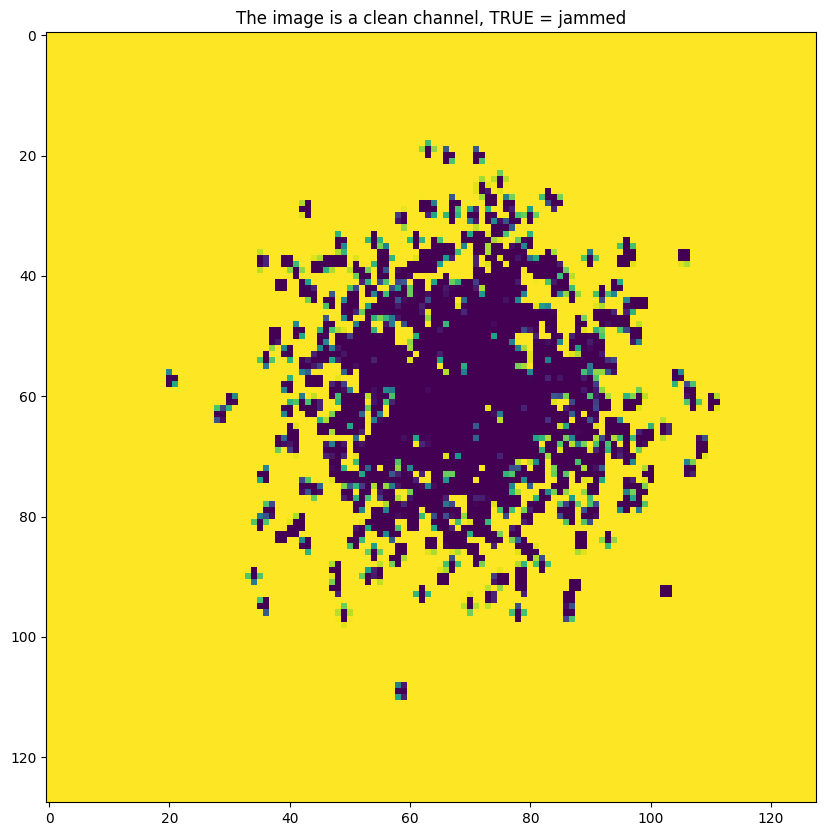

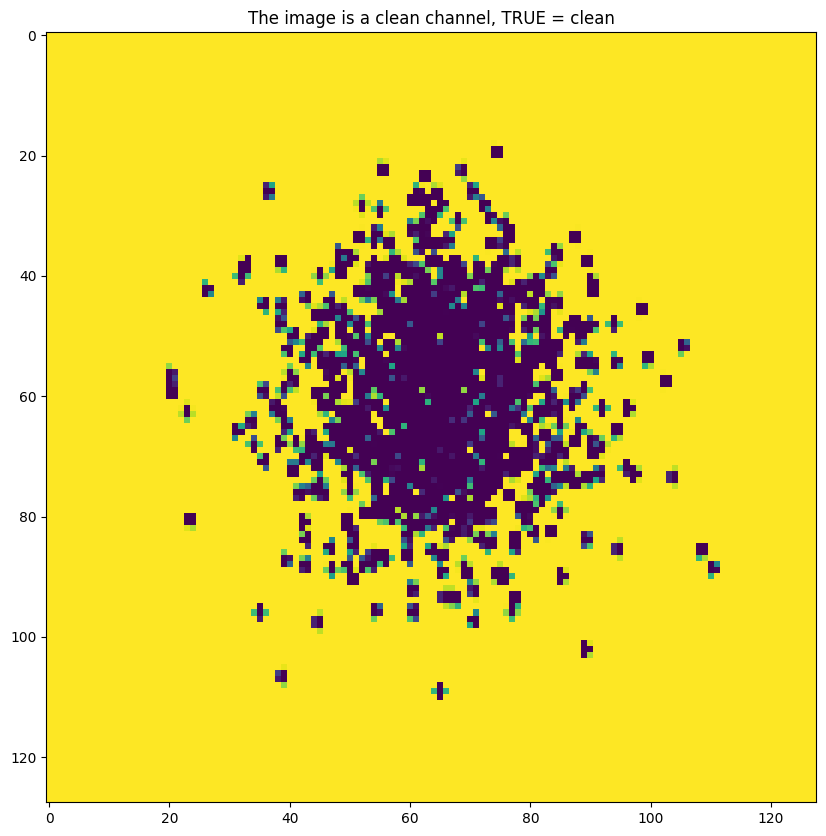

In [19]:
#anomaly verification for one image, just to see
num=random.randint(0,len(anomalies))
check_anomaly(anomalies[num], labels_anomalies[num],normal_values[0]+normal_values[1]) ## i set a chosen threshold

#same procedure as before
num=random.randint(0,len(val))
check_anomaly(val[num],labels_val[num],normal_values[0]+normal_values[1])

In [20]:
def compute_fn_fp(gt,pred):
  fp=0
  fn=0
  for i in range(len(gt)):
    if(gt[i]==0 and pred[i]==1):
      fp=fp+1
    if(gt[i]==1 and pred[i]==0):
      fn=fn+1
  return fn/len(gt),fp/len(gt)


In [23]:
values_th=np.arange(normal_values[0],jammed_values[0],0.00005)
print(len(values_th))

38


In [24]:
errors=[]
for im in tqdm(test):
  img=im.reshape(1,128,128,1)/255.
  er=model.evaluate(img,img,batch_size=1)
  errors.append(er)

print(len(errors))

  0%|          | 0/800 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0259


  0%|          | 2/800 [00:00<00:49, 16.13it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0270


  0%|          | 4/800 [00:00<00:48, 16.31it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0261


  1%|          | 6/800 [00:00<00:48, 16.36it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0246


  1%|          | 8/800 [00:00<00:48, 16.34it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0286


  1%|▏         | 10/800 [00:00<00:48, 16.31it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0295


  2%|▏         | 12/800 [00:00<00:49, 16.08it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0302


  2%|▏         | 14/800 [00:00<00:48, 16.06it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0274


  2%|▏         | 16/800 [00:00<00:47, 16.58it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0265


  2%|▏         | 18/800 [00:01<00:47, 16.37it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0309


  2%|▎         | 20/800 [00:01<00:49, 15.63it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0274


  3%|▎         | 22/800 [00:01<00:50, 15.53it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0290


  3%|▎         | 24/800 [00:01<00:48, 15.95it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0262


  3%|▎         | 26/800 [00:01<00:49, 15.63it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0273


  4%|▎         | 28/800 [00:01<00:49, 15.53it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0282


  4%|▍         | 30/800 [00:01<00:49, 15.67it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0286


  4%|▍         | 32/800 [00:02<00:49, 15.64it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0313


  4%|▍         | 34/800 [00:02<00:48, 15.80it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0311


  4%|▍         | 36/800 [00:02<00:49, 15.48it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0317


  5%|▍         | 38/800 [00:02<00:47, 15.89it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0311


  5%|▌         | 40/800 [00:02<00:47, 15.95it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0290


  5%|▌         | 42/800 [00:02<00:46, 16.21it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0270


  6%|▌         | 44/800 [00:02<00:47, 15.95it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0276


  6%|▌         | 46/800 [00:02<00:48, 15.65it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0288


  6%|▌         | 48/800 [00:03<00:47, 15.78it/s]

1/1 [==============================] - 0s 20ms/step - loss: 0.0290


  6%|▋         | 50/800 [00:03<00:46, 16.21it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0268


  6%|▋         | 52/800 [00:03<00:44, 16.83it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0283


  7%|▋         | 54/800 [00:03<00:46, 16.00it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0290


  7%|▋         | 56/800 [00:03<00:46, 16.03it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0290


  7%|▋         | 58/800 [00:03<00:46, 15.80it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0332


  8%|▊         | 60/800 [00:03<00:46, 15.79it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0276


  8%|▊         | 62/800 [00:03<00:45, 16.38it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0282


  8%|▊         | 64/800 [00:04<00:47, 15.66it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0262


  8%|▊         | 66/800 [00:04<00:46, 15.91it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0314


  8%|▊         | 68/800 [00:04<00:46, 15.79it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0290


  9%|▉         | 70/800 [00:04<00:46, 15.85it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0305


  9%|▉         | 72/800 [00:04<00:46, 15.61it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0266


  9%|▉         | 74/800 [00:04<00:47, 15.13it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0246


 10%|▉         | 76/800 [00:04<00:48, 14.99it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0312


 10%|▉         | 78/800 [00:04<00:46, 15.63it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0312


 10%|█         | 80/800 [00:05<00:45, 15.94it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0343


 10%|█         | 82/800 [00:05<00:45, 15.90it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0291


 10%|█         | 84/800 [00:05<00:43, 16.39it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0292


 11%|█         | 86/800 [00:05<00:44, 15.99it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0253


 11%|█         | 88/800 [00:05<00:44, 16.01it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0343


 11%|█▏        | 90/800 [00:05<00:45, 15.52it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0280


 12%|█▏        | 92/800 [00:05<00:44, 16.02it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0342


 12%|█▏        | 94/800 [00:05<00:44, 15.77it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0295


 12%|█▏        | 96/800 [00:06<00:43, 16.08it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0301


 12%|█▏        | 98/800 [00:06<00:43, 15.99it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0281


 12%|█▎        | 100/800 [00:06<00:44, 15.81it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0324


 13%|█▎        | 102/800 [00:06<00:43, 16.22it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0282


 13%|█▎        | 104/800 [00:06<00:42, 16.36it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0292


 13%|█▎        | 106/800 [00:06<00:42, 16.17it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0330


 14%|█▎        | 108/800 [00:06<00:43, 15.87it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0310


 14%|█▍        | 110/800 [00:06<00:42, 16.07it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0290


 14%|█▍        | 112/800 [00:07<00:41, 16.57it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0289


 14%|█▍        | 114/800 [00:07<00:42, 16.33it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0340


 14%|█▍        | 116/800 [00:07<00:47, 14.53it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0289


 15%|█▍        | 118/800 [00:07<00:50, 13.52it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0283


 15%|█▌        | 120/800 [00:07<00:51, 13.33it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0259


 15%|█▌        | 122/800 [00:07<00:53, 12.76it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0262


 16%|█▌        | 124/800 [00:08<00:56, 12.00it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0254


 16%|█▌        | 126/800 [00:08<00:57, 11.78it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0332


 16%|█▌        | 128/800 [00:08<00:56, 11.87it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0286


 16%|█▋        | 130/800 [00:08<00:56, 11.92it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0285


 16%|█▋        | 132/800 [00:08<00:57, 11.52it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0260


 17%|█▋        | 134/800 [00:08<00:57, 11.49it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0283


 17%|█▋        | 136/800 [00:09<00:57, 11.63it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0306


 17%|█▋        | 138/800 [00:09<00:56, 11.82it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0307


 18%|█▊        | 140/800 [00:09<01:00, 10.90it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0260


 18%|█▊        | 142/800 [00:09<00:58, 11.21it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0296


 18%|█▊        | 144/800 [00:09<00:55, 11.75it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0306


 18%|█▊        | 146/800 [00:09<00:51, 12.69it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0262


 18%|█▊        | 148/800 [00:10<00:48, 13.44it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0298


 19%|█▉        | 150/800 [00:10<00:45, 14.19it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0280


 19%|█▉        | 152/800 [00:10<00:43, 14.79it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0260


 19%|█▉        | 154/800 [00:10<00:43, 14.86it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0265


 20%|█▉        | 156/800 [00:10<00:42, 15.12it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0304


 20%|█▉        | 158/800 [00:10<00:41, 15.44it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0294


 20%|██        | 160/800 [00:10<00:42, 15.17it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0292


 20%|██        | 162/800 [00:10<00:42, 15.17it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0330


 20%|██        | 164/800 [00:11<00:41, 15.46it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0294


 21%|██        | 166/800 [00:11<00:40, 15.56it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0305


 21%|██        | 168/800 [00:11<00:41, 15.15it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0298


 21%|██▏       | 170/800 [00:11<00:40, 15.51it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0262


 22%|██▏       | 172/800 [00:11<00:40, 15.60it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0280


 22%|██▏       | 174/800 [00:11<00:39, 15.72it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0289


 22%|██▏       | 176/800 [00:11<00:40, 15.46it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0308


 22%|██▏       | 178/800 [00:11<00:39, 15.55it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0269


 22%|██▎       | 180/800 [00:12<00:39, 15.65it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0270


 23%|██▎       | 182/800 [00:12<00:39, 15.83it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0267


 23%|██▎       | 184/800 [00:12<00:39, 15.61it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0295


 23%|██▎       | 186/800 [00:12<00:39, 15.53it/s]

1/1 [==============================] - 0s 20ms/step - loss: 0.0311


 24%|██▎       | 188/800 [00:12<00:39, 15.68it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0291


 24%|██▍       | 190/800 [00:12<00:39, 15.55it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0258


 24%|██▍       | 192/800 [00:12<00:40, 15.19it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0242


 24%|██▍       | 194/800 [00:12<00:39, 15.35it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0264


 24%|██▍       | 196/800 [00:13<00:38, 15.52it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0266


 25%|██▍       | 198/800 [00:13<00:38, 15.54it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0260


 25%|██▌       | 200/800 [00:13<00:39, 15.23it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0286


 25%|██▌       | 202/800 [00:13<00:38, 15.38it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0231


 26%|██▌       | 204/800 [00:13<00:37, 15.90it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0307


 26%|██▌       | 206/800 [00:13<00:38, 15.38it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0268


 26%|██▌       | 208/800 [00:13<00:38, 15.22it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0274


 26%|██▋       | 210/800 [00:13<00:39, 15.06it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0300


 26%|██▋       | 212/800 [00:14<00:39, 15.04it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0364


 27%|██▋       | 214/800 [00:14<00:38, 15.34it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0278


 27%|██▋       | 216/800 [00:14<00:37, 15.44it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0260


 27%|██▋       | 218/800 [00:14<00:37, 15.70it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0264


 28%|██▊       | 220/800 [00:14<00:37, 15.29it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0288


 28%|██▊       | 222/800 [00:14<00:36, 15.84it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0281


 28%|██▊       | 224/800 [00:14<00:37, 15.29it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0294


 28%|██▊       | 226/800 [00:15<00:36, 15.55it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0271


 28%|██▊       | 228/800 [00:15<00:38, 15.03it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0304


 29%|██▉       | 230/800 [00:15<00:37, 15.30it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0263


 29%|██▉       | 232/800 [00:15<00:36, 15.43it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0286


 29%|██▉       | 234/800 [00:15<00:37, 15.09it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0292


 30%|██▉       | 236/800 [00:15<00:37, 15.11it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0274


 30%|██▉       | 238/800 [00:15<00:37, 14.92it/s]

1/1 [==============================] - 0s 20ms/step - loss: 0.0281


 30%|███       | 240/800 [00:15<00:35, 15.67it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0301


 30%|███       | 242/800 [00:16<00:35, 15.79it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0297


 30%|███       | 244/800 [00:16<00:34, 16.23it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0306


 31%|███       | 246/800 [00:16<00:35, 15.60it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0315


 31%|███       | 248/800 [00:16<00:35, 15.42it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0244


 31%|███▏      | 250/800 [00:16<00:34, 15.75it/s]

1/1 [==============================] - 0s 20ms/step - loss: 0.0277


 32%|███▏      | 252/800 [00:16<00:34, 16.03it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0307


 32%|███▏      | 254/800 [00:16<00:35, 15.51it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0272


 32%|███▏      | 256/800 [00:16<00:35, 15.33it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0266


 32%|███▏      | 258/800 [00:17<00:35, 15.13it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0311


 32%|███▎      | 260/800 [00:17<00:34, 15.48it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0319


 33%|███▎      | 262/800 [00:17<00:34, 15.56it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0307


 33%|███▎      | 264/800 [00:17<00:34, 15.41it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0241


 33%|███▎      | 266/800 [00:17<00:34, 15.39it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0312


 34%|███▎      | 268/800 [00:17<00:34, 15.64it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0305


 34%|███▍      | 270/800 [00:17<00:34, 15.45it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0292


 34%|███▍      | 272/800 [00:18<00:34, 15.38it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0308


 34%|███▍      | 274/800 [00:18<00:37, 14.11it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0297


 34%|███▍      | 276/800 [00:18<00:36, 14.40it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0303


 35%|███▍      | 278/800 [00:18<00:35, 14.75it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0273


 35%|███▌      | 280/800 [00:18<00:35, 14.55it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0299


 35%|███▌      | 282/800 [00:18<00:34, 15.10it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0277


 36%|███▌      | 284/800 [00:18<00:34, 15.17it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0310


 36%|███▌      | 286/800 [00:18<00:33, 15.36it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0275


 36%|███▌      | 288/800 [00:19<00:32, 15.69it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0257


 36%|███▋      | 290/800 [00:19<00:32, 15.47it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0300


 36%|███▋      | 292/800 [00:19<00:31, 15.98it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0296


 37%|███▋      | 294/800 [00:19<00:31, 15.85it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0324


 37%|███▋      | 296/800 [00:19<00:34, 14.45it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0279


 37%|███▋      | 298/800 [00:19<00:38, 13.09it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0320


 38%|███▊      | 300/800 [00:19<00:40, 12.45it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0298


 38%|███▊      | 302/800 [00:20<00:41, 11.98it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0288


 38%|███▊      | 304/800 [00:20<00:41, 11.93it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0379


 38%|███▊      | 306/800 [00:20<00:42, 11.74it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0294


 38%|███▊      | 308/800 [00:20<00:42, 11.66it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0296


 39%|███▉      | 310/800 [00:20<00:41, 11.89it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0333


 39%|███▉      | 312/800 [00:21<00:40, 11.98it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0271


 39%|███▉      | 314/800 [00:21<00:40, 11.94it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0286


 40%|███▉      | 316/800 [00:21<00:41, 11.68it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0291


 40%|███▉      | 318/800 [00:21<00:41, 11.63it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0289


 40%|████      | 320/800 [00:21<00:41, 11.50it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0285


 40%|████      | 322/800 [00:21<00:41, 11.50it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0273


 40%|████      | 324/800 [00:22<00:38, 12.24it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0307


 41%|████      | 326/800 [00:22<00:35, 13.26it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0305


 41%|████      | 328/800 [00:22<00:34, 13.74it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0258


 41%|████▏     | 330/800 [00:22<00:33, 14.20it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0289


 42%|████▏     | 332/800 [00:22<00:32, 14.30it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0319


 42%|████▏     | 334/800 [00:22<00:30, 15.24it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0259


 42%|████▏     | 336/800 [00:22<00:29, 15.82it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0287


 42%|████▏     | 338/800 [00:22<00:28, 16.39it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0262


 42%|████▎     | 340/800 [00:23<00:28, 15.93it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0301


 43%|████▎     | 342/800 [00:23<00:28, 16.15it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0300


 43%|████▎     | 344/800 [00:23<00:28, 16.09it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0297


 43%|████▎     | 346/800 [00:23<00:28, 15.84it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0308


 44%|████▎     | 348/800 [00:23<00:27, 16.25it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0290


 44%|████▍     | 350/800 [00:23<00:28, 15.80it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0294


 44%|████▍     | 352/800 [00:23<00:28, 15.79it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0271


 44%|████▍     | 354/800 [00:23<00:28, 15.78it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0281


 44%|████▍     | 356/800 [00:24<00:29, 15.12it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0316


 45%|████▍     | 358/800 [00:24<00:29, 14.85it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0260


 45%|████▌     | 360/800 [00:24<00:29, 14.96it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0284


 45%|████▌     | 362/800 [00:24<00:29, 14.98it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0308


 46%|████▌     | 364/800 [00:24<00:30, 14.52it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0350


 46%|████▌     | 366/800 [00:24<00:29, 14.56it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0266


 46%|████▌     | 368/800 [00:24<00:30, 14.17it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0257


 46%|████▋     | 370/800 [00:25<00:29, 14.46it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0305


 46%|████▋     | 372/800 [00:25<00:28, 14.85it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0298


 47%|████▋     | 374/800 [00:25<00:28, 14.82it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0282


 47%|████▋     | 376/800 [00:25<00:28, 14.82it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0283


 47%|████▋     | 378/800 [00:25<00:28, 15.06it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0295


 48%|████▊     | 380/800 [00:25<00:27, 15.10it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0296


 48%|████▊     | 382/800 [00:25<00:27, 15.21it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0267


 48%|████▊     | 384/800 [00:25<00:27, 14.89it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0275


 48%|████▊     | 386/800 [00:26<00:27, 14.96it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0301


 48%|████▊     | 388/800 [00:26<00:27, 14.74it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0264


 49%|████▉     | 390/800 [00:26<00:27, 15.00it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0293


 49%|████▉     | 392/800 [00:26<00:27, 14.97it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0282


 49%|████▉     | 394/800 [00:26<00:26, 15.11it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0337


 50%|████▉     | 396/800 [00:26<00:26, 15.00it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0272


 50%|████▉     | 398/800 [00:26<00:26, 15.25it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0297


 50%|█████     | 400/800 [00:26<00:26, 15.29it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0309


 50%|█████     | 402/800 [00:27<00:26, 14.87it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0279


 50%|█████     | 404/800 [00:27<00:26, 15.12it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0299


 51%|█████     | 406/800 [00:27<00:25, 15.39it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0339


 51%|█████     | 408/800 [00:27<00:25, 15.35it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0302


 51%|█████▏    | 410/800 [00:27<00:26, 14.95it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0311


 52%|█████▏    | 412/800 [00:27<00:25, 15.30it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0264


 52%|█████▏    | 414/800 [00:27<00:25, 15.36it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0303


 52%|█████▏    | 416/800 [00:28<00:25, 15.24it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0268


 52%|█████▏    | 418/800 [00:28<00:25, 15.13it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0267


 52%|█████▎    | 420/800 [00:28<00:25, 15.14it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0286


 53%|█████▎    | 422/800 [00:28<00:24, 15.29it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0272


 53%|█████▎    | 424/800 [00:28<00:24, 15.29it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0272


 53%|█████▎    | 426/800 [00:28<00:24, 15.46it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0263


 54%|█████▎    | 428/800 [00:28<00:24, 15.30it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0280


 54%|█████▍    | 430/800 [00:28<00:23, 15.52it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0277


 54%|█████▍    | 432/800 [00:29<00:23, 15.68it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0311


 54%|█████▍    | 434/800 [00:29<00:23, 15.65it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0281


 55%|█████▍    | 436/800 [00:29<00:24, 14.99it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0306


 55%|█████▍    | 438/800 [00:29<00:24, 15.05it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0310


 55%|█████▌    | 440/800 [00:29<00:23, 15.17it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0272


 55%|█████▌    | 442/800 [00:29<00:23, 15.06it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0269


 56%|█████▌    | 444/800 [00:29<00:23, 15.03it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0269


 56%|█████▌    | 446/800 [00:30<00:22, 15.52it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0343


 56%|█████▌    | 448/800 [00:30<00:22, 15.43it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0301


 56%|█████▋    | 450/800 [00:30<00:22, 15.62it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0294


 56%|█████▋    | 452/800 [00:30<00:23, 14.96it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0247


 57%|█████▋    | 454/800 [00:30<00:23, 14.85it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0232


 57%|█████▋    | 456/800 [00:30<00:23, 14.66it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0302


 57%|█████▋    | 458/800 [00:30<00:22, 15.01it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0280


 57%|█████▊    | 460/800 [00:30<00:22, 15.28it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0303


 58%|█████▊    | 462/800 [00:31<00:22, 14.79it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0288


 58%|█████▊    | 464/800 [00:31<00:23, 14.52it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0248


 58%|█████▊    | 466/800 [00:31<00:22, 15.17it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0265


 58%|█████▊    | 468/800 [00:31<00:22, 14.94it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0302


 59%|█████▉    | 470/800 [00:31<00:22, 14.69it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0308


 59%|█████▉    | 472/800 [00:31<00:22, 14.57it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0301


 59%|█████▉    | 474/800 [00:31<00:22, 14.56it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0301


 60%|█████▉    | 476/800 [00:32<00:24, 13.20it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0297


 60%|█████▉    | 478/800 [00:32<00:25, 12.82it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0291


 60%|██████    | 480/800 [00:32<00:26, 12.26it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0254


 60%|██████    | 482/800 [00:32<00:26, 11.85it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0307


 60%|██████    | 484/800 [00:32<00:26, 11.74it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0264


 61%|██████    | 486/800 [00:32<00:26, 11.70it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0291


 61%|██████    | 488/800 [00:33<00:27, 11.51it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0347


 61%|██████▏   | 490/800 [00:33<00:27, 11.30it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0292


 62%|██████▏   | 492/800 [00:33<00:26, 11.54it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0283


 62%|██████▏   | 494/800 [00:33<00:26, 11.75it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0251


 62%|██████▏   | 496/800 [00:33<00:25, 11.77it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0277


 62%|██████▏   | 498/800 [00:33<00:25, 11.71it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0259


 62%|██████▎   | 500/800 [00:34<00:25, 11.73it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0314


 63%|██████▎   | 502/800 [00:34<00:25, 11.63it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0220


 63%|██████▎   | 504/800 [00:34<00:24, 11.94it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0348


 63%|██████▎   | 506/800 [00:34<00:23, 12.57it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0315


 64%|██████▎   | 508/800 [00:34<00:22, 13.14it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0308


 64%|██████▍   | 510/800 [00:34<00:21, 13.74it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0297


 64%|██████▍   | 512/800 [00:35<00:20, 14.05it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0243


 64%|██████▍   | 514/800 [00:35<00:19, 14.46it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0295


 64%|██████▍   | 516/800 [00:35<00:19, 14.63it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0322


 65%|██████▍   | 518/800 [00:35<00:19, 14.68it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0288


 65%|██████▌   | 520/800 [00:35<00:18, 15.11it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0275


 65%|██████▌   | 522/800 [00:35<00:18, 15.14it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0267


 66%|██████▌   | 524/800 [00:36<00:32,  8.51it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0261


 66%|██████▌   | 526/800 [00:36<00:29,  9.24it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0305


 66%|██████▌   | 528/800 [00:36<00:27, 10.06it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0230


 66%|██████▋   | 530/800 [00:36<00:25, 10.68it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0295


 66%|██████▋   | 532/800 [00:36<00:23, 11.24it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0307


 67%|██████▋   | 534/800 [00:36<00:22, 11.82it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0281


 67%|██████▋   | 536/800 [00:37<00:21, 12.21it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0304


 67%|██████▋   | 538/800 [00:37<00:21, 12.46it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0299


 68%|██████▊   | 540/800 [00:37<00:20, 12.40it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0280


 68%|██████▊   | 542/800 [00:37<00:20, 12.51it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0280


 68%|██████▊   | 544/800 [00:37<00:20, 12.71it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0299


 68%|██████▊   | 546/800 [00:37<00:19, 12.72it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0291


 68%|██████▊   | 548/800 [00:38<00:20, 12.58it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0291


 69%|██████▉   | 550/800 [00:38<00:19, 12.74it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0291


 69%|██████▉   | 552/800 [00:38<00:19, 12.87it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0276


 69%|██████▉   | 554/800 [00:38<00:18, 13.28it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0295


 70%|██████▉   | 556/800 [00:38<00:18, 12.94it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0251


 70%|██████▉   | 558/800 [00:38<00:18, 12.99it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0284


 70%|███████   | 560/800 [00:38<00:18, 13.06it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0272


 70%|███████   | 562/800 [00:39<00:18, 13.08it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0273


 70%|███████   | 564/800 [00:39<00:18, 12.96it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0290


 71%|███████   | 566/800 [00:39<00:18, 12.93it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0250


 71%|███████   | 568/800 [00:39<00:17, 13.08it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0244


 71%|███████▏  | 570/800 [00:39<00:17, 13.24it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0294


 72%|███████▏  | 572/800 [00:39<00:17, 13.17it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0261


 72%|███████▏  | 574/800 [00:40<00:17, 13.14it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0271


 72%|███████▏  | 576/800 [00:40<00:16, 13.23it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0281


 72%|███████▏  | 578/800 [00:40<00:16, 13.44it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0356


 72%|███████▎  | 580/800 [00:40<00:16, 13.20it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0308


 73%|███████▎  | 582/800 [00:40<00:16, 12.93it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0291


 73%|███████▎  | 584/800 [00:40<00:16, 13.14it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0271


 73%|███████▎  | 586/800 [00:40<00:15, 13.49it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0279


 74%|███████▎  | 588/800 [00:41<00:15, 13.47it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0340


 74%|███████▍  | 590/800 [00:41<00:15, 13.42it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0284


 74%|███████▍  | 592/800 [00:41<00:15, 13.31it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0290


 74%|███████▍  | 594/800 [00:41<00:15, 13.06it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0294


 74%|███████▍  | 596/800 [00:41<00:15, 12.96it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0300


 75%|███████▍  | 598/800 [00:41<00:15, 13.12it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0262


 75%|███████▌  | 600/800 [00:41<00:14, 13.36it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0274


 75%|███████▌  | 602/800 [00:42<00:14, 13.67it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0295


 76%|███████▌  | 604/800 [00:42<00:13, 14.24it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0307


 76%|███████▌  | 606/800 [00:42<00:13, 14.41it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0294


 76%|███████▌  | 608/800 [00:42<00:13, 14.01it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0295


 76%|███████▋  | 610/800 [00:42<00:13, 14.13it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0293


 76%|███████▋  | 612/800 [00:42<00:12, 14.55it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0305


 77%|███████▋  | 614/800 [00:42<00:12, 14.50it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0315


 77%|███████▋  | 616/800 [00:43<00:12, 14.23it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0263


 77%|███████▋  | 618/800 [00:43<00:12, 14.60it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0289


 78%|███████▊  | 620/800 [00:43<00:12, 14.87it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0312


 78%|███████▊  | 622/800 [00:43<00:12, 14.69it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0291


 78%|███████▊  | 624/800 [00:43<00:11, 14.77it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0261


 78%|███████▊  | 626/800 [00:43<00:11, 14.56it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0307


 78%|███████▊  | 628/800 [00:43<00:11, 14.43it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0285


 79%|███████▉  | 630/800 [00:44<00:11, 14.78it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0314


 79%|███████▉  | 632/800 [00:44<00:11, 14.87it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0238


 79%|███████▉  | 634/800 [00:44<00:11, 14.77it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0257


 80%|███████▉  | 636/800 [00:44<00:11, 14.68it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0312


 80%|███████▉  | 638/800 [00:44<00:12, 13.00it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0295


 80%|████████  | 640/800 [00:44<00:13, 11.92it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0278


 80%|████████  | 642/800 [00:45<00:13, 11.66it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0296


 80%|████████  | 644/800 [00:45<00:13, 11.57it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0318


 81%|████████  | 646/800 [00:45<00:13, 11.36it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0276


 81%|████████  | 648/800 [00:45<00:13, 11.36it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0299


 81%|████████▏ | 650/800 [00:45<00:13, 11.05it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0287


 82%|████████▏ | 652/800 [00:45<00:13, 10.84it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0289


 82%|████████▏ | 654/800 [00:46<00:13, 11.14it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0283


 82%|████████▏ | 656/800 [00:46<00:12, 11.35it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0252


 82%|████████▏ | 658/800 [00:46<00:12, 11.48it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0298


 82%|████████▎ | 660/800 [00:46<00:12, 10.93it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0312


 83%|████████▎ | 662/800 [00:46<00:12, 10.85it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0299


 83%|████████▎ | 664/800 [00:47<00:12, 10.75it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0290


 83%|████████▎ | 666/800 [00:47<00:11, 11.60it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0292


 84%|████████▎ | 668/800 [00:47<00:10, 12.38it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0261


 84%|████████▍ | 670/800 [00:47<00:10, 12.88it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0285


 84%|████████▍ | 672/800 [00:47<00:09, 13.10it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0304


 84%|████████▍ | 674/800 [00:47<00:09, 13.77it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0296


 84%|████████▍ | 676/800 [00:47<00:08, 13.83it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0304


 85%|████████▍ | 678/800 [00:48<00:08, 14.09it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0269


 85%|████████▌ | 680/800 [00:48<00:08, 14.80it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0259


 85%|████████▌ | 682/800 [00:48<00:08, 14.32it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0291


 86%|████████▌ | 684/800 [00:48<00:08, 14.25it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0295


 86%|████████▌ | 686/800 [00:48<00:07, 14.48it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0279


 86%|████████▌ | 688/800 [00:48<00:07, 14.53it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0309


 86%|████████▋ | 690/800 [00:48<00:07, 14.70it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0256


 86%|████████▋ | 692/800 [00:48<00:07, 14.84it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0292


 87%|████████▋ | 694/800 [00:49<00:07, 14.54it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0295


 87%|████████▋ | 696/800 [00:49<00:06, 15.14it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0262


 87%|████████▋ | 698/800 [00:49<00:06, 15.18it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0294


 88%|████████▊ | 700/800 [00:49<00:06, 15.37it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0307


 88%|████████▊ | 702/800 [00:49<00:06, 14.65it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0245


 88%|████████▊ | 704/800 [00:49<00:06, 15.10it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0298


 88%|████████▊ | 706/800 [00:49<00:06, 14.64it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0291


 88%|████████▊ | 708/800 [00:50<00:06, 15.01it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0286


 89%|████████▉ | 710/800 [00:50<00:06, 14.49it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0289


 89%|████████▉ | 712/800 [00:50<00:06, 14.45it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0266


 89%|████████▉ | 714/800 [00:50<00:05, 14.60it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0275


 90%|████████▉ | 716/800 [00:50<00:05, 14.92it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0287


 90%|████████▉ | 718/800 [00:50<00:05, 14.61it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0296


 90%|█████████ | 720/800 [00:50<00:05, 14.79it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0303


 90%|█████████ | 722/800 [00:50<00:05, 14.59it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0310


 90%|█████████ | 724/800 [00:51<00:05, 14.35it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0321


 91%|█████████ | 726/800 [00:51<00:05, 14.56it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0290


 91%|█████████ | 728/800 [00:51<00:04, 14.48it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0282


 91%|█████████▏| 730/800 [00:51<00:04, 14.79it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0312


 92%|█████████▏| 732/800 [00:51<00:04, 14.36it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0307


 92%|█████████▏| 734/800 [00:51<00:04, 14.62it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0362


 92%|█████████▏| 736/800 [00:51<00:04, 14.60it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0286


 92%|█████████▏| 738/800 [00:52<00:04, 14.97it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0297


 92%|█████████▎| 740/800 [00:52<00:03, 15.32it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0306


 93%|█████████▎| 742/800 [00:52<00:03, 14.70it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0291


 93%|█████████▎| 744/800 [00:52<00:03, 14.96it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0289


 93%|█████████▎| 746/800 [00:52<00:03, 14.93it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0297


 94%|█████████▎| 748/800 [00:52<00:03, 14.63it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0273


 94%|█████████▍| 750/800 [00:52<00:03, 14.86it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0271


 94%|█████████▍| 752/800 [00:53<00:03, 15.03it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0292


 94%|█████████▍| 754/800 [00:53<00:03, 14.61it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0290


 94%|█████████▍| 756/800 [00:53<00:02, 14.74it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0260


 95%|█████████▍| 758/800 [00:53<00:02, 14.93it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0250


 95%|█████████▌| 760/800 [00:53<00:02, 14.75it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0260


 95%|█████████▌| 762/800 [00:53<00:02, 14.48it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0251


 96%|█████████▌| 764/800 [00:53<00:02, 15.14it/s]

1/1 [==============================] - 0s 19ms/step - loss: 0.0286


 96%|█████████▌| 766/800 [00:53<00:02, 15.53it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0288


 96%|█████████▌| 768/800 [00:54<00:02, 15.60it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0280


 96%|█████████▋| 770/800 [00:54<00:01, 15.09it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0305


 96%|█████████▋| 772/800 [00:54<00:01, 15.05it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0290


 97%|█████████▋| 774/800 [00:54<00:01, 14.87it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0274


 97%|█████████▋| 776/800 [00:54<00:01, 15.18it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0307


 97%|█████████▋| 778/800 [00:54<00:01, 14.72it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0270


 98%|█████████▊| 780/800 [00:54<00:01, 14.65it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0285


 98%|█████████▊| 782/800 [00:55<00:01, 14.63it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0294


 98%|█████████▊| 784/800 [00:55<00:01, 14.77it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0288


 98%|█████████▊| 786/800 [00:55<00:00, 14.93it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0268


 98%|█████████▊| 788/800 [00:55<00:00, 14.77it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0297


 99%|█████████▉| 790/800 [00:55<00:00, 14.66it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0291


 99%|█████████▉| 792/800 [00:55<00:00, 14.69it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0307


 99%|█████████▉| 794/800 [00:55<00:00, 14.73it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0301


100%|█████████▉| 796/800 [00:55<00:00, 14.80it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0295


100%|█████████▉| 798/800 [00:56<00:00, 15.13it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0263


100%|██████████| 800/800 [00:56<00:00, 14.23it/s]

800


In [25]:
def compute_predictions(th,errors):
  pred=[]
  for err in errors:
    if(err>th):
      pred.append(1)
    else:
      pred.append(0)
  return pred

In [26]:
false_neg=[]
false_pos=[]
for t in values_th:
  predictions=compute_predictions(t,errors)
  probs=compute_fn_fp(labels_test,predictions)
  false_neg.append(probs[0])
  false_pos.append(probs[1])

In [27]:
print(false_neg)
print(false_pos)

[0.065, 0.07, 0.07125, 0.07625, 0.07875, 0.08, 0.085, 0.09, 0.0925, 0.09375, 0.09875, 0.09875, 0.10375, 0.105, 0.10875, 0.11375, 0.11625, 0.1175, 0.1225, 0.13, 0.13375, 0.135, 0.13875, 0.1525, 0.1575, 0.16125, 0.16625, 0.17375, 0.1825, 0.19, 0.19875, 0.20375, 0.205, 0.21125, 0.21375, 0.22, 0.23625, 0.2425]
[0.27375, 0.27125, 0.265, 0.265, 0.26375, 0.26125, 0.26, 0.25375, 0.2525, 0.25, 0.245, 0.24, 0.2375, 0.23375, 0.2275, 0.22625, 0.22375, 0.22125, 0.2125, 0.2075, 0.2025, 0.20125, 0.19625, 0.19375, 0.19125, 0.18875, 0.1825, 0.17625, 0.17, 0.16375, 0.1575, 0.1525, 0.145, 0.14125, 0.13375, 0.125, 0.11875, 0.11]


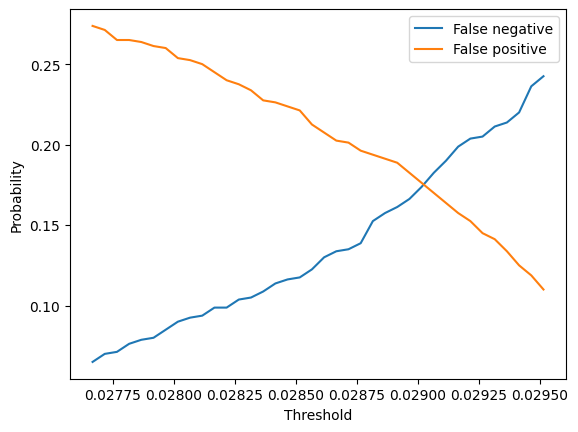

In [28]:
plt.plot(values_th,false_neg,label="False negative")
plt.plot(values_th,false_pos,label="False positive")
plt.xlabel("Threshold")
plt.ylabel("Probability")
plt.legend()
plt.show()

In [29]:
pred=[]
for im in tqdm(test):
    
    img= im.reshape(1,128,128,1)/255.
    error=model.evaluate(img,img,batch_size=1)
    if(error<normal_values[0]+normal_values[1]):
      pred.append(0)
    else:
      pred.append(1)

correct=np.array(pred)==np.array(labels_test)

## make predictions on the test set and create a mask where we can see if the prediction was correct

  0%|          | 0/800 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0259


  0%|          | 2/800 [00:00<00:48, 16.52it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0270


  0%|          | 4/800 [00:00<00:47, 16.82it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0261


  1%|          | 6/800 [00:00<00:48, 16.36it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0246


  1%|          | 8/800 [00:00<01:12, 10.89it/s]

1/1 [==============================] - 0s 51ms/step - loss: 0.0286


  1%|▏         | 10/800 [00:00<01:25,  9.27it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0295


  2%|▏         | 12/800 [00:01<01:30,  8.69it/s]

1/1 [==============================] - 0s 60ms/step - loss: 0.0315


  2%|▏         | 13/800 [00:01<01:32,  8.50it/s]

1/1 [==============================] - 0s 50ms/step - loss: 0.0302


  2%|▏         | 14/800 [00:01<01:36,  8.18it/s]

1/1 [==============================] - 0s 93ms/step - loss: 0.0276


  2%|▏         | 15/800 [00:01<01:57,  6.67it/s]

1/1 [==============================] - 0s 50ms/step - loss: 0.0274


  2%|▏         | 16/800 [00:01<01:56,  6.72it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0282


  2%|▏         | 17/800 [00:01<01:55,  6.77it/s]

1/1 [==============================] - 0s 84ms/step - loss: 0.0265


  2%|▏         | 18/800 [00:02<02:02,  6.38it/s]

1/1 [==============================] - 0s 60ms/step - loss: 0.0227


  2%|▏         | 19/800 [00:02<02:06,  6.19it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0278


  3%|▎         | 21/800 [00:02<01:36,  8.07it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0289


  3%|▎         | 23/800 [00:02<01:17, 10.00it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0269


  3%|▎         | 25/800 [00:02<01:08, 11.33it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0289


  3%|▎         | 27/800 [00:02<01:01, 12.59it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0288


  4%|▎         | 29/800 [00:02<00:57, 13.46it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0274


  4%|▍         | 31/800 [00:03<00:54, 14.16it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0232


  4%|▍         | 33/800 [00:03<00:53, 14.40it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0307


  4%|▍         | 35/800 [00:03<00:52, 14.65it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0302


  5%|▍         | 37/800 [00:03<00:50, 15.14it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0296


  5%|▍         | 39/800 [00:03<00:50, 14.99it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0235


  5%|▌         | 41/800 [00:03<00:53, 14.20it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0295


  5%|▌         | 43/800 [00:03<00:52, 14.39it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0289


  6%|▌         | 45/800 [00:04<00:50, 14.88it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0292


  6%|▌         | 47/800 [00:04<00:49, 15.18it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0312


  6%|▌         | 49/800 [00:04<00:49, 15.31it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0286


  6%|▋         | 51/800 [00:04<00:49, 15.11it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0294


  7%|▋         | 53/800 [00:04<00:50, 14.71it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0378


  7%|▋         | 55/800 [00:04<00:49, 15.17it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0305


  7%|▋         | 57/800 [00:04<00:48, 15.47it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0268


  7%|▋         | 59/800 [00:04<00:47, 15.66it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0304


  8%|▊         | 61/800 [00:05<00:47, 15.68it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0284


  8%|▊         | 63/800 [00:05<00:45, 16.06it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0264


  8%|▊         | 65/800 [00:05<00:45, 16.26it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0309


  8%|▊         | 67/800 [00:05<00:44, 16.63it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0274


  9%|▊         | 69/800 [00:05<00:45, 16.03it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0285


  9%|▉         | 71/800 [00:05<00:44, 16.22it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0280


  9%|▉         | 73/800 [00:05<00:45, 15.83it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0275


  9%|▉         | 75/800 [00:05<00:45, 15.88it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0266


 10%|▉         | 77/800 [00:06<00:45, 15.76it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0292


 10%|▉         | 79/800 [00:06<00:44, 16.11it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0325


 10%|█         | 81/800 [00:06<00:44, 16.30it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0277


 10%|█         | 83/800 [00:06<00:46, 15.31it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0365


 11%|█         | 85/800 [00:06<00:53, 13.48it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0260


 11%|█         | 87/800 [00:06<00:55, 12.73it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0305


 11%|█         | 89/800 [00:06<00:55, 12.75it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0284


 11%|█▏        | 91/800 [00:07<00:56, 12.49it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0286


 12%|█▏        | 93/800 [00:07<00:58, 12.13it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0270


 12%|█▏        | 95/800 [00:07<00:58, 11.98it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0309


 12%|█▏        | 97/800 [00:07<01:00, 11.69it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0339


 12%|█▏        | 99/800 [00:07<01:00, 11.63it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0258


 13%|█▎        | 101/800 [00:08<01:00, 11.48it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0286


 13%|█▎        | 103/800 [00:08<01:00, 11.47it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0255


 13%|█▎        | 105/800 [00:08<01:01, 11.31it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0261


 13%|█▎        | 107/800 [00:08<01:01, 11.20it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0268


 14%|█▎        | 109/800 [00:08<01:00, 11.48it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0294


 14%|█▍        | 111/800 [00:08<00:54, 12.61it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0305


 14%|█▍        | 113/800 [00:09<00:53, 12.95it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0301


 14%|█▍        | 115/800 [00:09<00:50, 13.67it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0339


 15%|█▍        | 117/800 [00:09<00:48, 13.98it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0301


 15%|█▍        | 119/800 [00:09<00:47, 14.29it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0313


 15%|█▌        | 121/800 [00:09<00:46, 14.66it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0301


 15%|█▌        | 123/800 [00:09<00:44, 15.20it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0314


 16%|█▌        | 125/800 [00:09<00:43, 15.52it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0300


 16%|█▌        | 127/800 [00:09<00:42, 15.65it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0281


 16%|█▌        | 129/800 [00:10<00:43, 15.27it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0301


 16%|█▋        | 131/800 [00:10<00:44, 15.14it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0330


 17%|█▋        | 133/800 [00:10<00:44, 14.97it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0264


 17%|█▋        | 135/800 [00:10<00:44, 15.00it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0303


 17%|█▋        | 137/800 [00:10<00:44, 14.90it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0244


 17%|█▋        | 139/800 [00:10<00:44, 14.94it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0313


 18%|█▊        | 141/800 [00:10<00:44, 14.90it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0300


 18%|█▊        | 143/800 [00:10<00:43, 14.97it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0279


 18%|█▊        | 145/800 [00:11<00:42, 15.46it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0356


 18%|█▊        | 147/800 [00:11<00:42, 15.36it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0272


 19%|█▊        | 149/800 [00:11<00:42, 15.16it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0287


 19%|█▉        | 151/800 [00:11<00:44, 14.60it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0271


 19%|█▉        | 153/800 [00:11<00:43, 14.72it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0241


 19%|█▉        | 155/800 [00:11<00:44, 14.47it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0294


 20%|█▉        | 157/800 [00:11<00:43, 14.87it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0299


 20%|█▉        | 159/800 [00:12<00:42, 15.10it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0293


 20%|██        | 161/800 [00:12<00:40, 15.64it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0286


 20%|██        | 163/800 [00:12<00:41, 15.50it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0345


 21%|██        | 165/800 [00:12<00:40, 15.72it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0305


 21%|██        | 167/800 [00:12<00:40, 15.50it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0283


 21%|██        | 169/800 [00:12<00:40, 15.76it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0232


 21%|██▏       | 171/800 [00:12<00:40, 15.71it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0295


 22%|██▏       | 173/800 [00:12<00:40, 15.48it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0256


 22%|██▏       | 175/800 [00:13<00:40, 15.52it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0292


 22%|██▏       | 177/800 [00:13<00:40, 15.45it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0264


 22%|██▏       | 179/800 [00:13<00:39, 15.87it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0312


 23%|██▎       | 181/800 [00:13<00:38, 15.89it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0263


 23%|██▎       | 183/800 [00:13<00:39, 15.81it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0287


 23%|██▎       | 185/800 [00:13<00:38, 15.79it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0280


 23%|██▎       | 187/800 [00:13<00:40, 15.29it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0271


 24%|██▎       | 189/800 [00:13<00:42, 14.52it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0306


 24%|██▍       | 191/800 [00:14<00:41, 14.57it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0231


 24%|██▍       | 193/800 [00:14<00:40, 14.92it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0292


 24%|██▍       | 195/800 [00:14<00:40, 14.82it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0300


 25%|██▍       | 197/800 [00:14<00:40, 14.93it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0327


 25%|██▍       | 199/800 [00:14<00:40, 14.71it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0265


 25%|██▌       | 201/800 [00:14<00:40, 14.84it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0291


 25%|██▌       | 203/800 [00:14<00:38, 15.44it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0309


 26%|██▌       | 205/800 [00:15<00:37, 15.81it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0281


 26%|██▌       | 207/800 [00:15<00:36, 16.05it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0304


 26%|██▌       | 209/800 [00:15<00:37, 15.91it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0266


 26%|██▋       | 211/800 [00:15<00:36, 16.29it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0294


 27%|██▋       | 213/800 [00:15<00:37, 15.74it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0268


 27%|██▋       | 215/800 [00:15<00:38, 15.13it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0307


 27%|██▋       | 217/800 [00:15<00:39, 14.78it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0313


 27%|██▋       | 219/800 [00:15<00:38, 15.24it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0309


 28%|██▊       | 221/800 [00:16<00:37, 15.52it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0316


 28%|██▊       | 223/800 [00:16<00:37, 15.32it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0292


 28%|██▊       | 225/800 [00:16<00:38, 15.03it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0322


 28%|██▊       | 227/800 [00:16<00:38, 15.07it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0278


 29%|██▊       | 229/800 [00:16<00:36, 15.59it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0289


 29%|██▉       | 231/800 [00:16<00:36, 15.40it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0285


 29%|██▉       | 233/800 [00:16<00:37, 15.16it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0236


 29%|██▉       | 235/800 [00:16<00:36, 15.33it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0288


 30%|██▉       | 237/800 [00:17<00:37, 15.12it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0265


 30%|██▉       | 239/800 [00:17<00:36, 15.51it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0268


 30%|███       | 241/800 [00:17<00:36, 15.42it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0274


 30%|███       | 243/800 [00:17<00:35, 15.56it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0303


 31%|███       | 245/800 [00:17<00:35, 15.50it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0293


 31%|███       | 247/800 [00:17<00:36, 15.22it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0307


 31%|███       | 249/800 [00:17<00:36, 15.00it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0278


 31%|███▏      | 251/800 [00:18<00:35, 15.38it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0286


 32%|███▏      | 253/800 [00:18<00:34, 15.93it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0282


 32%|███▏      | 255/800 [00:18<00:34, 15.92it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0277


 32%|███▏      | 257/800 [00:18<00:33, 16.01it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0273


 32%|███▏      | 259/800 [00:18<00:35, 15.22it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0292


 33%|███▎      | 261/800 [00:18<00:35, 15.20it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0262


 33%|███▎      | 263/800 [00:18<00:36, 14.60it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0295


 33%|███▎      | 265/800 [00:18<00:39, 13.65it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0266


 33%|███▎      | 267/800 [00:19<00:40, 13.03it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0291


 34%|███▎      | 269/800 [00:19<00:44, 11.86it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0324


 34%|███▍      | 271/800 [00:19<00:44, 11.82it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0308


 34%|███▍      | 273/800 [00:19<00:45, 11.57it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0281


 34%|███▍      | 275/800 [00:19<00:45, 11.49it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0285


 35%|███▍      | 277/800 [00:20<00:45, 11.57it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0303


 35%|███▍      | 279/800 [00:20<00:42, 12.16it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0287


 35%|███▌      | 281/800 [00:20<00:42, 12.27it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0253


 35%|███▌      | 283/800 [00:20<00:41, 12.33it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0262


 36%|███▌      | 285/800 [00:20<00:43, 11.90it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0275


 36%|███▌      | 287/800 [00:20<00:45, 11.38it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0305


 36%|███▌      | 289/800 [00:21<00:44, 11.44it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0265


 36%|███▋      | 291/800 [00:21<00:43, 11.60it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0273


 37%|███▋      | 293/800 [00:21<00:41, 12.36it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0303


 37%|███▋      | 295/800 [00:21<00:38, 13.10it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0310


 37%|███▋      | 297/800 [00:21<00:37, 13.54it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0311


 37%|███▋      | 299/800 [00:21<00:35, 13.97it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0278


 38%|███▊      | 301/800 [00:21<00:35, 13.99it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0311


 38%|███▊      | 303/800 [00:22<00:33, 14.77it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0290


 38%|███▊      | 305/800 [00:22<00:32, 15.12it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0301


 38%|███▊      | 307/800 [00:22<00:32, 15.09it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0295


 39%|███▊      | 309/800 [00:22<00:31, 15.41it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0300


 39%|███▉      | 311/800 [00:22<00:32, 14.96it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0326


 39%|███▉      | 313/800 [00:22<00:31, 15.31it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0299


 39%|███▉      | 315/800 [00:22<00:31, 15.60it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0303


 40%|███▉      | 317/800 [00:22<00:30, 15.79it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0300


 40%|███▉      | 319/800 [00:23<00:31, 15.47it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0304


 40%|████      | 321/800 [00:23<00:31, 15.40it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0318


 40%|████      | 323/800 [00:23<00:30, 15.58it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0240


 41%|████      | 325/800 [00:23<00:30, 15.60it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0309


 41%|████      | 327/800 [00:23<00:30, 15.57it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0283


 41%|████      | 329/800 [00:23<00:31, 15.07it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0311


 41%|████▏     | 331/800 [00:23<00:30, 15.46it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0295


 42%|████▏     | 333/800 [00:23<00:30, 15.47it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0290


 42%|████▏     | 335/800 [00:24<00:29, 15.96it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0334


 42%|████▏     | 337/800 [00:24<00:30, 15.27it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0278


 42%|████▏     | 339/800 [00:24<00:30, 15.15it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0295


 43%|████▎     | 341/800 [00:24<00:30, 15.02it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0299


 43%|████▎     | 343/800 [00:24<00:30, 15.22it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0320


 43%|████▎     | 345/800 [00:24<00:30, 14.83it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0311


 43%|████▎     | 347/800 [00:24<00:29, 15.18it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0302


 44%|████▎     | 349/800 [00:25<00:29, 15.04it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0262


 44%|████▍     | 351/800 [00:25<00:29, 15.16it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0273


 44%|████▍     | 353/800 [00:25<00:29, 15.33it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0229


 44%|████▍     | 355/800 [00:25<00:29, 15.22it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0294


 45%|████▍     | 357/800 [00:25<00:28, 15.30it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0276


 45%|████▍     | 359/800 [00:25<00:27, 15.78it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0255


 45%|████▌     | 361/800 [00:25<00:28, 15.61it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0297


 45%|████▌     | 363/800 [00:25<00:28, 15.27it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0284


 46%|████▌     | 365/800 [00:26<00:29, 14.55it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0272


 46%|████▌     | 367/800 [00:26<00:29, 14.80it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0306


 46%|████▌     | 369/800 [00:26<00:28, 15.05it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0268


 46%|████▋     | 371/800 [00:26<00:29, 14.51it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0335


 47%|████▋     | 373/800 [00:26<00:28, 14.73it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0319


 47%|████▋     | 375/800 [00:26<00:28, 15.08it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0291


 47%|████▋     | 377/800 [00:26<00:28, 15.10it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0293


 47%|████▋     | 379/800 [00:27<00:28, 14.68it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0293


 48%|████▊     | 381/800 [00:27<00:28, 14.68it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0304


 48%|████▊     | 383/800 [00:27<00:28, 14.59it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0270


 48%|████▊     | 385/800 [00:27<00:28, 14.69it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0300


 48%|████▊     | 387/800 [00:27<00:27, 14.82it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0305


 49%|████▊     | 389/800 [00:27<00:27, 15.16it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0293


 49%|████▉     | 391/800 [00:27<00:27, 15.05it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0276


 49%|████▉     | 393/800 [00:27<00:26, 15.24it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0294


 49%|████▉     | 395/800 [00:28<00:26, 15.04it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0269


 50%|████▉     | 397/800 [00:28<00:27, 14.64it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0283


 50%|████▉     | 399/800 [00:28<00:27, 14.77it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0301


 50%|█████     | 401/800 [00:28<00:26, 15.05it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0274


 50%|█████     | 403/800 [00:28<00:26, 15.16it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0272


 51%|█████     | 405/800 [00:28<00:26, 15.14it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0271


 51%|█████     | 407/800 [00:28<00:25, 15.22it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0257


 51%|█████     | 409/800 [00:29<00:25, 15.52it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0280


 51%|█████▏    | 411/800 [00:29<00:25, 15.25it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0270


 52%|█████▏    | 413/800 [00:29<00:25, 15.27it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0245


 52%|█████▏    | 415/800 [00:29<00:25, 14.87it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0277


 52%|█████▏    | 417/800 [00:29<00:25, 14.89it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0335


 52%|█████▏    | 419/800 [00:29<00:25, 14.76it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0296


 53%|█████▎    | 421/800 [00:29<00:24, 15.27it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0251


 53%|█████▎    | 423/800 [00:29<00:25, 15.05it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0298


 53%|█████▎    | 425/800 [00:30<00:25, 14.57it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0296


 53%|█████▎    | 427/800 [00:30<00:25, 14.70it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0258


 54%|█████▎    | 429/800 [00:30<00:24, 14.97it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0293


 54%|█████▍    | 431/800 [00:30<00:25, 14.68it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0287


 54%|█████▍    | 433/800 [00:30<00:24, 14.89it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0295


 54%|█████▍    | 435/800 [00:30<00:24, 14.99it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0315


 55%|█████▍    | 437/800 [00:30<00:23, 15.22it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0294


 55%|█████▍    | 439/800 [00:31<00:23, 15.34it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0309


 55%|█████▌    | 441/800 [00:31<00:24, 14.71it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0282


 55%|█████▌    | 443/800 [00:31<00:24, 14.31it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0295


 56%|█████▌    | 445/800 [00:31<00:26, 13.48it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0277


 56%|█████▌    | 447/800 [00:31<00:27, 12.98it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0260


 56%|█████▌    | 449/800 [00:31<00:27, 12.69it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0301


 56%|█████▋    | 451/800 [00:31<00:27, 12.54it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0279


 57%|█████▋    | 453/800 [00:32<00:28, 12.11it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0267


 57%|█████▋    | 455/800 [00:32<00:28, 12.30it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0262


 57%|█████▋    | 457/800 [00:32<00:27, 12.55it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0255


 57%|█████▋    | 459/800 [00:32<00:28, 11.81it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0286


 58%|█████▊    | 461/800 [00:32<00:29, 11.48it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0306


 58%|█████▊    | 463/800 [00:33<00:29, 11.41it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0311


 58%|█████▊    | 465/800 [00:33<00:29, 11.37it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0258


 58%|█████▊    | 467/800 [00:33<00:29, 11.13it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0318


 59%|█████▊    | 469/800 [00:33<00:29, 11.25it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0311


 59%|█████▉    | 471/800 [00:33<00:28, 11.70it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0286


 59%|█████▉    | 473/800 [00:33<00:27, 11.71it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0310


 59%|█████▉    | 475/800 [00:34<00:25, 12.51it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0288


 60%|█████▉    | 477/800 [00:34<00:24, 13.18it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0269


 60%|█████▉    | 479/800 [00:34<00:24, 13.35it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0304


 60%|██████    | 481/800 [00:34<00:22, 14.08it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0261


 60%|██████    | 483/800 [00:34<00:22, 13.87it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0277


 61%|██████    | 485/800 [00:34<00:22, 14.00it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0278


 61%|██████    | 487/800 [00:34<00:21, 14.61it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0283


 61%|██████    | 489/800 [00:34<00:20, 14.85it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0283


 61%|██████▏   | 491/800 [00:35<00:20, 14.92it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0291


 62%|██████▏   | 493/800 [00:35<00:20, 14.83it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0304


 62%|██████▏   | 495/800 [00:35<00:20, 14.77it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0294


 62%|██████▏   | 497/800 [00:35<00:20, 14.95it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0309


 62%|██████▏   | 499/800 [00:35<00:20, 14.91it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0269


 63%|██████▎   | 501/800 [00:35<00:20, 14.84it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0308


 63%|██████▎   | 503/800 [00:35<00:19, 15.22it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0284


 63%|██████▎   | 505/800 [00:36<00:19, 15.35it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0290


 63%|██████▎   | 507/800 [00:36<00:19, 15.20it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0267


 64%|██████▎   | 509/800 [00:36<00:19, 15.20it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0301


 64%|██████▍   | 511/800 [00:36<00:19, 14.83it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0295


 64%|██████▍   | 513/800 [00:36<00:19, 14.86it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0257


 64%|██████▍   | 515/800 [00:36<00:18, 15.17it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0316


 65%|██████▍   | 517/800 [00:36<00:18, 15.39it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0259


 65%|██████▍   | 519/800 [00:36<00:18, 15.47it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0283


 65%|██████▌   | 521/800 [00:37<00:18, 15.08it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0313


 65%|██████▌   | 523/800 [00:37<00:18, 15.27it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0331


 66%|██████▌   | 525/800 [00:37<00:18, 14.85it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0280


 66%|██████▌   | 527/800 [00:37<00:18, 14.60it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0341


 66%|██████▌   | 529/800 [00:37<00:18, 14.86it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0325


 66%|██████▋   | 531/800 [00:37<00:18, 14.82it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0260


 67%|██████▋   | 533/800 [00:37<00:17, 15.14it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0293


 67%|██████▋   | 535/800 [00:38<00:17, 15.04it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0276


 67%|██████▋   | 537/800 [00:38<00:17, 14.69it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0285


 67%|██████▋   | 539/800 [00:38<00:18, 14.40it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0262


 68%|██████▊   | 541/800 [00:38<00:17, 14.57it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0264


 68%|██████▊   | 543/800 [00:38<00:17, 14.69it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0297


 68%|██████▊   | 545/800 [00:38<00:17, 14.64it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0275


 68%|██████▊   | 547/800 [00:38<00:17, 14.53it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0277


 69%|██████▊   | 549/800 [00:38<00:17, 14.73it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0267


 69%|██████▉   | 551/800 [00:39<00:17, 14.65it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0292


 69%|██████▉   | 553/800 [00:39<00:17, 14.46it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0265


 69%|██████▉   | 555/800 [00:39<00:16, 14.62it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0293


 70%|██████▉   | 557/800 [00:39<00:16, 14.63it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0264


 70%|██████▉   | 559/800 [00:39<00:16, 14.49it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0305


 70%|███████   | 561/800 [00:39<00:16, 14.64it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0271


 70%|███████   | 563/800 [00:39<00:16, 14.47it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0270


 71%|███████   | 565/800 [00:40<00:15, 14.80it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0294


 71%|███████   | 567/800 [00:40<00:15, 14.93it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0290


 71%|███████   | 569/800 [00:40<00:15, 14.66it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0276


 71%|███████▏  | 571/800 [00:40<00:16, 14.31it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0295


 72%|███████▏  | 573/800 [00:40<00:15, 14.41it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0305


 72%|███████▏  | 575/800 [00:40<00:15, 14.73it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0291


 72%|███████▏  | 577/800 [00:40<00:14, 14.88it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0231


 72%|███████▏  | 579/800 [00:41<00:15, 14.62it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0238


 73%|███████▎  | 581/800 [00:41<00:26,  8.31it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0300


 73%|███████▎  | 583/800 [00:41<00:23,  9.31it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0307


 73%|███████▎  | 585/800 [00:41<00:21, 10.24it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0287


 73%|███████▎  | 587/800 [00:41<00:19, 11.02it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0243


 74%|███████▎  | 589/800 [00:42<00:18, 11.36it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0312


 74%|███████▍  | 591/800 [00:42<00:17, 11.78it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0294


 74%|███████▍  | 593/800 [00:42<00:17, 11.99it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0291


 74%|███████▍  | 595/800 [00:42<00:16, 12.09it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0290


 75%|███████▍  | 597/800 [00:42<00:16, 12.21it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0314


 75%|███████▍  | 599/800 [00:42<00:16, 12.43it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0325


 75%|███████▌  | 601/800 [00:43<00:15, 12.65it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0270


 75%|███████▌  | 603/800 [00:43<00:15, 12.76it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0294


 76%|███████▌  | 605/800 [00:43<00:15, 12.82it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0288


 76%|███████▌  | 607/800 [00:43<00:15, 12.70it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0293


 76%|███████▌  | 609/800 [00:43<00:14, 13.29it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0260


 76%|███████▋  | 611/800 [00:43<00:14, 13.07it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0298


 77%|███████▋  | 613/800 [00:44<00:16, 11.57it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0298


 77%|███████▋  | 615/800 [00:44<00:16, 10.93it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0280


 77%|███████▋  | 617/800 [00:44<00:17, 10.29it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0272


 77%|███████▋  | 619/800 [00:44<00:18,  9.92it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0287


 78%|███████▊  | 621/800 [00:44<00:18,  9.92it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0291


 78%|███████▊  | 623/800 [00:45<00:17, 10.22it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0243


 78%|███████▊  | 625/800 [00:45<00:17, 10.20it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0263


 78%|███████▊  | 627/800 [00:45<00:16, 10.32it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0314


 79%|███████▊  | 629/800 [00:45<00:16, 10.46it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0327


 79%|███████▉  | 631/800 [00:45<00:16, 10.30it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0330


 79%|███████▉  | 633/800 [00:46<00:15, 10.54it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0294


 79%|███████▉  | 635/800 [00:46<00:15, 10.50it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0290


 80%|███████▉  | 637/800 [00:46<00:15, 10.50it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0313


 80%|███████▉  | 639/800 [00:46<00:14, 11.12it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0294


 80%|████████  | 641/800 [00:46<00:13, 11.77it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0265


 80%|████████  | 643/800 [00:46<00:13, 12.06it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0298


 81%|████████  | 645/800 [00:47<00:12, 12.73it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0302


 81%|████████  | 647/800 [00:47<00:11, 12.99it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0286


 81%|████████  | 649/800 [00:47<00:11, 13.35it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0299


 81%|████████▏ | 651/800 [00:47<00:10, 13.65it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0283


 82%|████████▏ | 653/800 [00:47<00:10, 13.52it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0253


 82%|████████▏ | 655/800 [00:47<00:10, 13.89it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0293


 82%|████████▏ | 657/800 [00:47<00:10, 13.74it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0298


 82%|████████▏ | 659/800 [00:48<00:10, 14.00it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0291


 83%|████████▎ | 661/800 [00:48<00:09, 14.16it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0304


 83%|████████▎ | 663/800 [00:48<00:09, 14.34it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0309


 83%|████████▎ | 665/800 [00:48<00:09, 14.22it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0269


 83%|████████▎ | 667/800 [00:48<00:09, 14.25it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0267


 84%|████████▎ | 669/800 [00:48<00:09, 14.37it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0286


 84%|████████▍ | 671/800 [00:48<00:08, 14.53it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0271


 84%|████████▍ | 673/800 [00:48<00:08, 14.41it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0286


 84%|████████▍ | 675/800 [00:49<00:08, 14.41it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0298


 85%|████████▍ | 677/800 [00:49<00:08, 14.52it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0286


 85%|████████▍ | 679/800 [00:49<00:08, 14.13it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0268


 85%|████████▌ | 681/800 [00:49<00:08, 13.87it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0291


 85%|████████▌ | 683/800 [00:49<00:08, 14.08it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0292


 86%|████████▌ | 685/800 [00:49<00:08, 14.34it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0295


 86%|████████▌ | 687/800 [00:49<00:07, 14.52it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0292


 86%|████████▌ | 689/800 [00:50<00:07, 14.53it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0283


 86%|████████▋ | 691/800 [00:50<00:07, 14.49it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0288


 87%|████████▋ | 693/800 [00:50<00:07, 14.64it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0294


 87%|████████▋ | 695/800 [00:50<00:07, 14.74it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0311


 87%|████████▋ | 697/800 [00:50<00:07, 14.31it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0260


 87%|████████▋ | 699/800 [00:50<00:07, 14.37it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0288


 88%|████████▊ | 701/800 [00:50<00:06, 14.72it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0271


 88%|████████▊ | 703/800 [00:51<00:06, 14.89it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0295


 88%|████████▊ | 705/800 [00:51<00:06, 14.51it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0273


 88%|████████▊ | 707/800 [00:51<00:06, 14.62it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0294


 89%|████████▊ | 709/800 [00:51<00:06, 14.72it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0286


 89%|████████▉ | 711/800 [00:51<00:05, 15.00it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0314


 89%|████████▉ | 713/800 [00:51<00:05, 14.75it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0324


 89%|████████▉ | 715/800 [00:51<00:05, 14.44it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0301


 90%|████████▉ | 717/800 [00:52<00:05, 14.59it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0301


 90%|████████▉ | 719/800 [00:52<00:05, 14.97it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0230


 90%|█████████ | 721/800 [00:52<00:05, 15.15it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0306


 90%|█████████ | 723/800 [00:52<00:05, 14.83it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0293


 91%|█████████ | 725/800 [00:52<00:05, 14.68it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0270


 91%|█████████ | 727/800 [00:52<00:04, 14.67it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0267


 91%|█████████ | 729/800 [00:52<00:04, 14.95it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0281


 91%|█████████▏| 731/800 [00:52<00:04, 14.94it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0305


 92%|█████████▏| 733/800 [00:53<00:04, 14.83it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0269


 92%|█████████▏| 735/800 [00:53<00:04, 14.58it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0308


 92%|█████████▏| 737/800 [00:53<00:04, 14.46it/s]

1/1 [==============================] - 0s 20ms/step - loss: 0.0303


 92%|█████████▏| 739/800 [00:53<00:04, 14.70it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0299


 93%|█████████▎| 741/800 [00:53<00:04, 14.50it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0291


 93%|█████████▎| 743/800 [00:53<00:03, 14.71it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0297


 93%|█████████▎| 745/800 [00:53<00:03, 14.69it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0288


 93%|█████████▎| 747/800 [00:54<00:03, 13.43it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0290


 94%|█████████▎| 749/800 [00:54<00:03, 13.61it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0311


 94%|█████████▍| 751/800 [00:54<00:03, 13.92it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0295


 94%|█████████▍| 753/800 [00:54<00:03, 14.24it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0303


 94%|█████████▍| 755/800 [00:54<00:03, 14.38it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0294


 95%|█████████▍| 757/800 [00:54<00:02, 14.55it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0258


 95%|█████████▍| 759/800 [00:54<00:02, 14.44it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0299


 95%|█████████▌| 761/800 [00:55<00:02, 14.02it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0284


 95%|█████████▌| 763/800 [00:55<00:02, 14.39it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0249


 96%|█████████▌| 765/800 [00:55<00:02, 14.45it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0297


 96%|█████████▌| 767/800 [00:55<00:02, 14.01it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0257


 96%|█████████▌| 769/800 [00:55<00:02, 14.13it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0280


 96%|█████████▋| 771/800 [00:55<00:02, 14.12it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0263


 97%|█████████▋| 773/800 [00:55<00:01, 14.76it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0296


 97%|█████████▋| 775/800 [00:56<00:01, 14.64it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0272


 97%|█████████▋| 777/800 [00:56<00:01, 14.38it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0308


 97%|█████████▋| 779/800 [00:56<00:01, 14.78it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0288


 98%|█████████▊| 781/800 [00:56<00:01, 14.48it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0269


 98%|█████████▊| 783/800 [00:56<00:01, 13.13it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0295


 98%|█████████▊| 785/800 [00:56<00:01, 12.24it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0297


 98%|█████████▊| 787/800 [00:57<00:01, 11.45it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0301


 99%|█████████▊| 789/800 [00:57<00:00, 11.81it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0303


 99%|█████████▉| 791/800 [00:57<00:00, 11.61it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0307


 99%|█████████▉| 793/800 [00:57<00:00, 11.30it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0309


 99%|█████████▉| 795/800 [00:57<00:00, 11.00it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0297


100%|█████████▉| 797/800 [00:57<00:00, 10.98it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0260


100%|█████████▉| 799/800 [00:58<00:00, 10.67it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0263


100%|██████████| 800/800 [00:58<00:00, 13.74it/s]


In [30]:
print("The overall accuracy of the predictor is:",np.sum(correct)/len(pred)*100,"%") ## print the overall accuracy of this predictor

The overall accuracy of the predictor is: 62.125 %


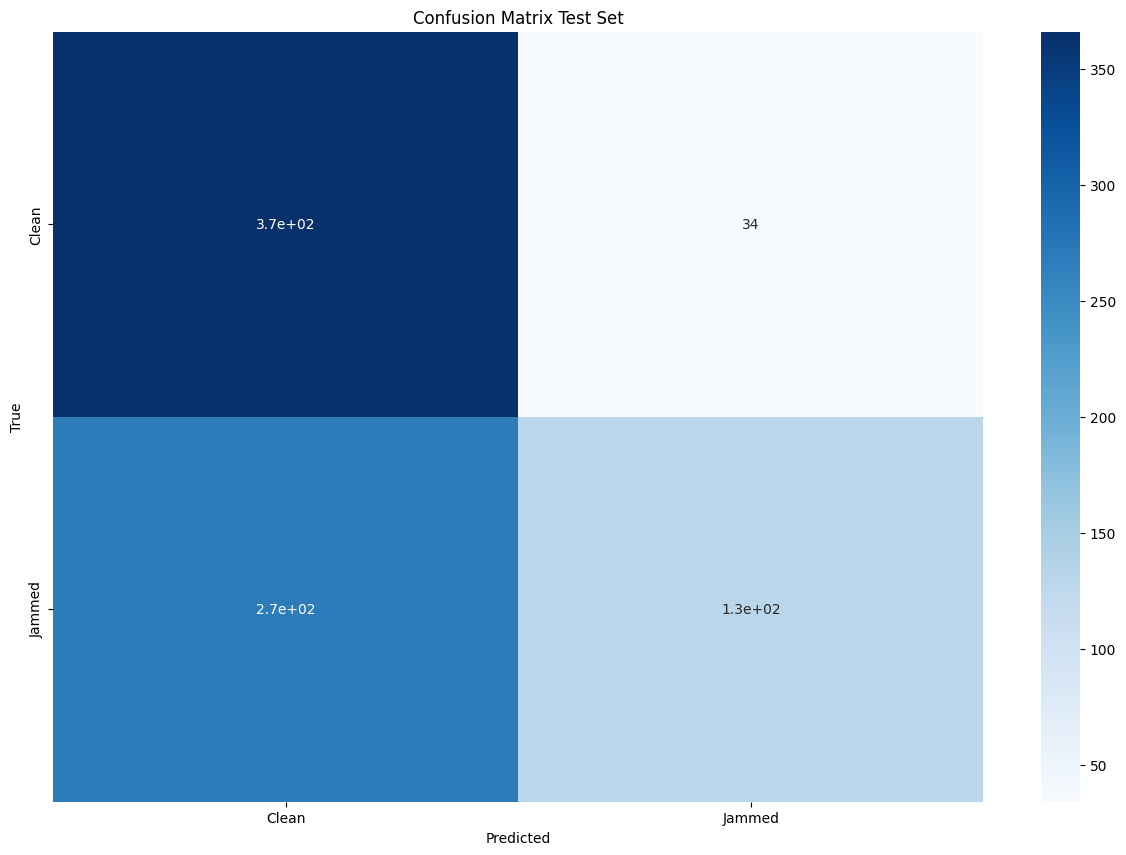

In [31]:
def print_confusion_matrix(gt, pred):
    class_names= {0: "Clean", 1:"Jammed"}
    num_classes = 2
    cm = confusion_matrix(y_true=gt, y_pred=pred)
    df_cm = pd.DataFrame(cm, index = class_names.values(), columns = class_names.values())
    plt.figure(figsize = (15,10))
    sn.heatmap(df_cm, annot=True, cmap='Blues')
    plt.title('Confusion Matrix Test Set')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

print_confusion_matrix(labels_test,pred) ## print the confusion matrix of our predictor for a given threshold